In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sklearn
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns

from copy import deepcopy
import warnings
import pytz
import time
import numpy as np
import pandas as pd
import pickle
from datetime import datetime, timedelta
from enum import Enum
from collections import namedtuple, defaultdict
import gzip
import random
import os
import json
import polars as pl

In [3]:
# Common plotting settings
# plt.rcParams.update({
#     'font.size': 7,          # Base font size
#     'axes.labelsize': 7,     # Font size for x and y labels
#     'axes.titlesize': 8,     # Slightly larger title for emphasis
#     'xtick.labelsize': 6,     # Slightly smaller tick labels
#     'ytick.labelsize': 6,     # Slightly smaller tick labels
#     'legend.fontsize': 6,     # Smaller legend font
#     'figure.dpi': 300,       # High DPI for clarity
#     'savefig.dpi': 300,      # High DPI for saved figures
#     'legend.framealpha': 0.8, # Add some transparency to the legend frame
#     'axes.linewidth': 0.8,   # Slightly thinner axes lines
#     'xtick.major.size': 3,    # Shorter major tick marks
#     'ytick.major.size': 3,    # Shorter major tick marks
#     'xtick.minor.size': 1.5,  # Shorter minor tick marks
#     'ytick.minor.size': 1.5,  # Shorter minor tick marks
#     'xtick.major.pad': 2,     # Reduce padding around ticks
#     'ytick.major.pad': 2,     # Reduce padding around ticks
#     'legend.handlelength': 1.2, # Shorter legend handles
#     'legend.labelspacing': 0.8, # Reduce spacing between legend labels
#     'lines.linewidth': 1.0    # Slightly thinner lines in plots
# })

plt.rcParams.update({
    'font.size': 10,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.linewidth': 0.8,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.minor.width': 0.5,
    'ytick.minor.width': 0.5,
    'lines.linewidth': 1.2,
    'patch.linewidth': 0.8,
    'grid.linewidth': 0.5,
    'legend.frameon': True,
    'legend.fancybox': False,
    'legend.edgecolor': 'black',
    'legend.framealpha': 1.0
})

#### Reading data and changing column names

In [77]:
df = pd.read_csv('simulation_data_for_journal_paper.csv')
df = df.rename(columns={
                'Number of charger': 'NumberOfChargers',
                'Number of priority evs': 'NumberOfPriorityEVs',
                'Total number of EV': 'TotalEVs',
                'Total Energy delivered: withoutSmartCharging': 'EnergyDelivered_uncontrolled',
                'Total Energy delivered: RR': 'EnergyDelivered_RoundRobin',
                'Total Energy delivered: LLF': 'EnergyDelivered_LeastLaxityFirst',
                'Total Energy delivered: MPC': 'EnergyDelivered_MPC_AdaptiveQueue',
                'Total charging cost: withoutSmartCharging': 'ChargingCost_uncontrolled',
                'Total charging cost: RR': 'ChargingCost_RoundRobin',
                'Total charging cost: LLF': 'ChargingCost_LeastLaxityFirst',
                'Total charging cost: MPC': 'ChargingCost_MPC_AdaptiveQueue',
                'Priority EV served (%): withoutSmartCharging': 'PriorityEVsServed_uncontrolled',
                'Priority EV served (%): RR': 'PriorityEVsServed_RoundRobin',
                'Priority EV served (%): LLF': 'PriorityEVsServed_LeastLaxityFirst',
                'Priority EV served (%): MPC': 'PriorityEVsServed_MPC_AdaptiveQueue',
                })

#### For 9 EVSE based charging depot for fleet charging

In [70]:
# Read simulation_data_for_journal_paper.csv

df = df[df['NumberOfChargers'] == 9]
df.head(20)

,NumberOfChargers,Transformer capacity,NumberOfPriorityEVs,TotalEVs,EnergyDelivered_uncontrolled,EnergyDelivered_RoundRobin,EnergyDelivered_LeastLaxityFirst,EnergyDelivered_MPC_AdaptiveQueue,ChargingCost_uncontrolled,ChargingCost_RoundRobin,ChargingCost_LeastLaxityFirst,ChargingCost_MPC_AdaptiveQueue,PriorityEVsServed_uncontrolled,PriorityEVsServed_RoundRobin,PriorityEVsServed_LeastLaxityFirst,PriorityEVsServed_MPC_AdaptiveQueue
0,9,85,3,27,297,260.0,260.0,228.0,21.0,20.000,20.0,18.3,100,99.60,99.60,100
1,9,95,3,27,297,260.0,260.0,228.0,21.0,20.000,20.0,18.3,100,99.75,99.75,100
2,9,105,3,27,297,260.0,260.0,228.0,21.0,20.000,20.0,18.3,100,99.50,99.50,100
3,9,85,5,27,297,262.0,260.0,235.0,21.0,20.000,20.0,18.2,100,99.60,99.60,100
4,9,95,5,27,297,262.0,260.0,235.0,21.0,20.000,20.0,18.2,100,99.50,99.60,100
5,9,105,5,27,297,262.0,260.0,235.0,21.0,20.000,20.0,18.2,100,99.60,99.60,100
6,9,85,7,27,297,263.0,262.0,239.0,21.0,20.129,20.0,18.6,100,97.00,97.00,100
7,9,95,7,27,297,263.0,262.0,239.0,21.0,20.129,20.0,18.6,100,97.00,97.00,100
8,9,105,7,27,297,263.0,262.0,239.0,21.0,20.200,20.0,18.6,100,97.00,97.00,100


In [71]:
# Calculate the ratio of priority EVs to total EVs
df['priority_ev_ratio'] = (df['NumberOfPriorityEVs'] / df['TotalEVs'] * 100).round() # type: ignore

# Replace the values of priority_ev_ratio_cat in the dataframe with some predefine categories
df['priority_ev_ratio'] = df['priority_ev_ratio'].replace({
    11.0: 15.0,
    19.0: 20.0,
    26.0: 30.0,
})

df['priority_ev_ratio_cat'] = df['priority_ev_ratio'].astype(str)
# Sort by the original numeric ratio to ensure logical order on the x-axis for both plots
df = df.sort_values('priority_ev_ratio')
df

,NumberOfChargers,Transformer capacity,NumberOfPriorityEVs,TotalEVs,EnergyDelivered_uncontrolled,EnergyDelivered_RoundRobin,EnergyDelivered_LeastLaxityFirst,EnergyDelivered_MPC_AdaptiveQueue,ChargingCost_uncontrolled,ChargingCost_RoundRobin,ChargingCost_LeastLaxityFirst,ChargingCost_MPC_AdaptiveQueue,PriorityEVsServed_uncontrolled,PriorityEVsServed_RoundRobin,PriorityEVsServed_LeastLaxityFirst,PriorityEVsServed_MPC_AdaptiveQueue,priority_ev_ratio,priority_ev_ratio_cat
0,9,85,3,27,297,260.0,260.0,228.0,21.0,20.000,20.0,18.3,100,99.60,99.60,100,15.0,15.0
1,9,95,3,27,297,260.0,260.0,228.0,21.0,20.000,20.0,18.3,100,99.75,99.75,100,15.0,15.0
2,9,105,3,27,297,260.0,260.0,228.0,21.0,20.000,20.0,18.3,100,99.50,99.50,100,15.0,15.0
3,9,85,5,27,297,262.0,260.0,235.0,21.0,20.000,20.0,18.2,100,99.60,99.60,100,20.0,20.0
4,9,95,5,27,297,262.0,260.0,235.0,21.0,20.000,20.0,18.2,100,99.50,99.60,100,20.0,20.0
5,9,105,5,27,297,262.0,260.0,235.0,21.0,20.000,20.0,18.2,100,99.60,99.60,100,20.0,20.0
6,9,85,7,27,297,263.0,262.0,239.0,21.0,20.129,20.0,18.6,100,97.00,97.00,100,30.0,30.0
7,9,95,7,27,297,263.0,262.0,239.0,21.0,20.129,20.0,18.6,100,97.00,97.00,100,30.0,30.0
8,9,105,7,27,297,263.0,262.0,239.0,21.0,20.200,20.0,18.6,100,97.00,97.00,100,30.0,30.0


In [72]:
# reshape (melt) the dataframe to have a long format
df_cost_melted = df.melt(id_vars=['priority_ev_ratio_cat', 'priority_ev_ratio'],
                    value_vars=['ChargingCost_uncontrolled', 'ChargingCost_RoundRobin', 'ChargingCost_LeastLaxityFirst', 'ChargingCost_MPC_AdaptiveQueue'],
                    var_name='ChargingStrategy',
                    value_name='ChargingCost')
df_cost_melted['ChargingStrategy'] = df_cost_melted['ChargingStrategy'].str.replace('ChargingCost_', '')

In [73]:
# Melt the DataFrame for Energy Delivered
energy_value_vars = [
    'EnergyDelivered_uncontrolled',
    'EnergyDelivered_RoundRobin',
    'EnergyDelivered_LeastLaxityFirst',
    'EnergyDelivered_MPC_AdaptiveQueue'
]
df_energy_melted = df.melt(
    id_vars=['priority_ev_ratio_cat', 'priority_ev_ratio'],
    value_vars=energy_value_vars,
    var_name='charging_strategy',
    value_name='energy_value'
)
# Clean up the 'charging_strategy' names - ensure consistency with cost names for legend
df_energy_melted['charging_strategy'] = df_energy_melted['charging_strategy'].str.replace('EnergyDelivered_', '')
df_energy_melted['charging_strategy'] = df_energy_melted['charging_strategy'].str.replace('RoundRobin', 'RR') # Make it consistent
df_energy_melted['charging_strategy'] = df_energy_melted['charging_strategy'].str.replace('LeastLaxityFirst', 'LLF') # Make it consistent

In [74]:
# Melt the dataframe for Priority EVs Served
priority_value_vars = [
    'PriorityEVsServed_uncontrolled',
    'PriorityEVsServed_RoundRobin',
    'PriorityEVsServed_LeastLaxityFirst',
    'PriorityEVsServed_MPC_AdaptiveQueue'
]
df_priority_ev_served_melted = df.melt(
    id_vars=['priority_ev_ratio_cat', 'priority_ev_ratio'],
    value_vars=priority_value_vars,
    var_name='charging_strategy',
    value_name='priority_value'
)
# Clean up the 'charging_strategy' names - ensure consistency with cost names for legend
df_priority_ev_served_melted['charging_strategy'] = df_priority_ev_served_melted['charging_strategy'].str.replace('PriorityEVsServed_', '')
df_priority_ev_served_melted['charging_strategy'] = df_priority_ev_served_melted['charging_strategy'].str.replace('RoundRobin', 'RR') # Make it consistent  
df_priority_ev_served_melted['charging_strategy'] = df_priority_ev_served_melted['charging_strategy'].str.replace('LeastLaxityFirst', 'LLF') # Make it consistent

In [ ]:
# Make ratio categorical for distinct bars, especially for few unique ratio values
# or if they are very close numerically to avoid making x-axis messy.
# df_melted['priority_ev_ratio_cat'] = df_melted['priority_ev_ratio'].round(3).astype(str)
# Sort by the original numeric ratio to ensure logical order on the x-axis
# df_melted = df_melted.sort_values('priority_ev_ratio')

Plot saved as C:\Users\s3955218\OneDrive - RMIT University\PhD Writing\Journal\Simualtion_results\charging_cost_comparison_9evse.png


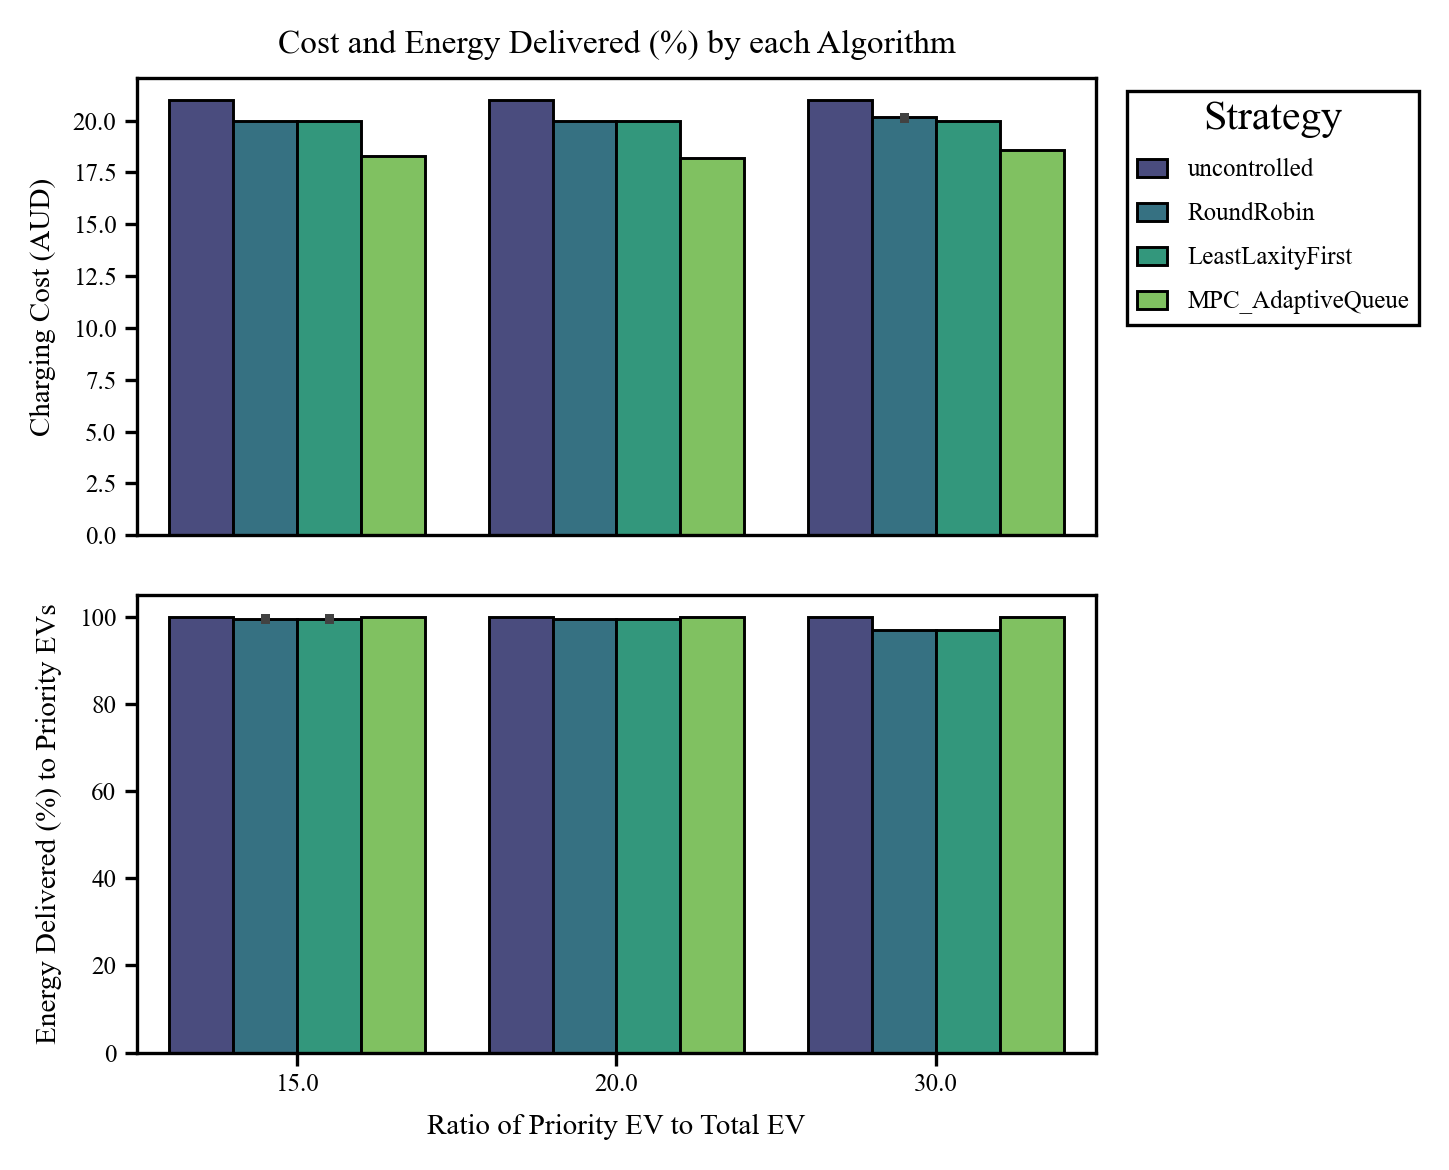

In [75]:
# Create the bar chart
# Adjust figure size: (width, height) in inches.
# Common single-column width is ~3.5 inches, double-column ~7 inches.
fig, axes = plt.subplots(2, 1, figsize=(3.5, 4), sharex=True) # 2 rows, 1 columm

# --- Plot 1: Charging Costs ---
sns.barplot(
    data=df_cost_melted,
    x='priority_ev_ratio', # Use the categorical version for distinct bars
    y='ChargingCost',
    hue='ChargingStrategy',
    palette='viridis', # Good for colorblindness and prints well in grayscale
    ax=axes[0],
    edgecolor='black', # Add edge color for better bar separation
    linewidth=0.7    # Linewidth for bar edges
)

axes[0].set_ylabel("Charging Cost (AUD)")
axes[0].set_title("Cost and Energy Delivered (%) by each Algorithm") # Main title on the first plot
axes[0].xaxis.set_visible(False) # Remove the x-axis from the top subplot
axes[0].legend(title="Strategy", bbox_to_anchor=(1.02, 1), loc='upper left')

# --- Plot 2: Energy Delivered ---
sns.barplot(
    data=df_priority_ev_served_melted,
    x='priority_ev_ratio',
    y='priority_value',
    hue='charging_strategy',
    palette='viridis', # Use same palette for consistency
    ax=axes[1],
    edgecolor='black',
    linewidth=0.7
)
axes[1].set_ylabel("Energy Delivered (%) to Priority EVs")
axes[1].set_xlabel("Ratio of Priority EV to Total EV") # X-label only on the bottom plot
axes[1].tick_params(axis='x', rotation=0) # Apply rotation here
# axes[1].legend(title="Strategy", bbox_to_anchor=(1.02, 1), loc='upper left') # Add legend if needed, or rely on the top one

# To prevent legend overlap if both are shown and placed outside, or use a single figure legend
# For now, we show legend on the first plot and can hide it on the second if the hue is identical.
if axes[0].get_legend() is not None and axes[1].get_legend() is not None:
    axes[1].get_legend().remove() # Remove second legend if first one is sufficient
# axes[0].get_legend().remove() # Option: remove legend if using a single figure legend later

# Ensure everything fits and save
plt.tight_layout(rect=[0, 0, 1.4, 1]) # Adjust rect to make space for legend outside plot area if needed

# Save in multiple formats
file_basename = "C:\\Users\\s3955218\\OneDrive - RMIT University\\PhD Writing\\Journal\\Simualtion_results\charging_cost_comparison_9evse"
plt.savefig(f"{file_basename}.png", dpi=300, bbox_inches='tight')
# plt.savefig(f"{file_basename}.pdf", dpi=300, bbox_inches='tight')
# plt.savefig(f"{file_basename}.svg", bbox_inches='tight')
# print(f"Plot saved as {file_basename}.png, {file_basename}.pdf, and {file_basename}.svg")
print(f"Plot saved as {file_basename}.png")

plt.show()

# Print the modified melted dataframe to show its structure (optional)
# print("\nModified Melted DataFrame structure (first 5 rows):")
# print(df_melted.head())

#### For 12 EVSE based charging depot for fleet charging

In [78]:
df = df[df['NumberOfChargers'] == 12]
df.head(20)

,NumberOfChargers,Transformer capacity,NumberOfPriorityEVs,TotalEVs,EnergyDelivered_uncontrolled,EnergyDelivered_RoundRobin,EnergyDelivered_LeastLaxityFirst,EnergyDelivered_MPC_AdaptiveQueue,ChargingCost_uncontrolled,ChargingCost_RoundRobin,ChargingCost_LeastLaxityFirst,ChargingCost_MPC_AdaptiveQueue,PriorityEVsServed_uncontrolled,PriorityEVsServed_RoundRobin,PriorityEVsServed_LeastLaxityFirst,PriorityEVsServed_MPC_AdaptiveQueue
9,12,95,5,36,524,438.5,439.0,406.0,38.192,33.197,33.270,33.67,100,96.0,96.0,100
10,12,110,5,36,524,442.0,439.2,404.6,38.192,33.168,33.217,33.50,100,97.0,96.0,100
11,12,120,5,36,524,439.0,439.0,406.0,38.192,33.161,33.160,33.67,100,96.0,96.0,100
12,12,95,7,36,524,439.0,438.0,422.0,38.192,33.228,33.287,35.00,100,95.0,95.0,100
13,12,110,7,36,524,439.0,439.0,422.0,38.192,33.172,33.195,35.00,100,95.0,95.0,100
14,12,120,7,36,524,439.0,439.0,422.0,38.192,33.163,33.182,35.00,100,95.0,95.0,100
15,12,95,10,36,524,439.0,439.0,435.0,38.192,33.200,33.300,36.20,100,95.0,96.0,100
16,12,110,10,36,524,439.0,439.0,435.0,38.192,33.200,33.170,36.20,100,95.0,96.0,100
17,12,120,10,36,524,439.0,439.0,435.0,38.192,34.000,33.170,36.20,100,95.0,96.0,100


In [79]:
# Calculate the ratio of priority EVs to total EVs
df['priority_ev_ratio'] = (df['NumberOfPriorityEVs'] / df['TotalEVs'] * 100).round() # type: ignore
df['priority_ev_ratio'] = df['priority_ev_ratio'].replace({
    14.0: 15.0,
    19.0: 20.0,
    28.0: 30.0,
})

df['priority_ev_ratio_cat'] = df['priority_ev_ratio'].astype(str) # type: ignore[name-defined]
# Sort by the original numeric ratio to ensure logical order on the x-axis for both plots
df = df.sort_values('priority_ev_ratio')
df

,NumberOfChargers,Transformer capacity,NumberOfPriorityEVs,TotalEVs,EnergyDelivered_uncontrolled,EnergyDelivered_RoundRobin,EnergyDelivered_LeastLaxityFirst,EnergyDelivered_MPC_AdaptiveQueue,ChargingCost_uncontrolled,ChargingCost_RoundRobin,ChargingCost_LeastLaxityFirst,ChargingCost_MPC_AdaptiveQueue,PriorityEVsServed_uncontrolled,PriorityEVsServed_RoundRobin,PriorityEVsServed_LeastLaxityFirst,PriorityEVsServed_MPC_AdaptiveQueue,priority_ev_ratio,priority_ev_ratio_cat
9,12,95,5,36,524,438.5,439.0,406.0,38.192,33.197,33.270,33.67,100,96.0,96.0,100,15.0,15.0
10,12,110,5,36,524,442.0,439.2,404.6,38.192,33.168,33.217,33.50,100,97.0,96.0,100,15.0,15.0
11,12,120,5,36,524,439.0,439.0,406.0,38.192,33.161,33.160,33.67,100,96.0,96.0,100,15.0,15.0
12,12,95,7,36,524,439.0,438.0,422.0,38.192,33.228,33.287,35.00,100,95.0,95.0,100,20.0,20.0
13,12,110,7,36,524,439.0,439.0,422.0,38.192,33.172,33.195,35.00,100,95.0,95.0,100,20.0,20.0
14,12,120,7,36,524,439.0,439.0,422.0,38.192,33.163,33.182,35.00,100,95.0,95.0,100,20.0,20.0
15,12,95,10,36,524,439.0,439.0,435.0,38.192,33.200,33.300,36.20,100,95.0,96.0,100,30.0,30.0
16,12,110,10,36,524,439.0,439.0,435.0,38.192,33.200,33.170,36.20,100,95.0,96.0,100,30.0,30.0
17,12,120,10,36,524,439.0,439.0,435.0,38.192,34.000,33.170,36.20,100,95.0,96.0,100,30.0,30.0


In [80]:
# reshape (melt) the dataframe to have a long format
df_cost_melted = df.melt(id_vars=['priority_ev_ratio_cat', 'priority_ev_ratio'],
                    value_vars=['ChargingCost_uncontrolled', 'ChargingCost_RoundRobin', 'ChargingCost_LeastLaxityFirst', 'ChargingCost_MPC_AdaptiveQueue'],
                    var_name='ChargingStrategy',
                    value_name='ChargingCost')
df_cost_melted['ChargingStrategy'] = df_cost_melted['ChargingStrategy'].str.replace('ChargingCost_', '')

In [81]:
# Melt the DataFrame for Energy Delivered
energy_value_vars = [
    'EnergyDelivered_uncontrolled',
    'EnergyDelivered_RoundRobin',
    'EnergyDelivered_LeastLaxityFirst',
    'EnergyDelivered_MPC_AdaptiveQueue'
]
df_energy_melted = df.melt(
    id_vars=['priority_ev_ratio_cat', 'priority_ev_ratio'],
    value_vars=energy_value_vars,
    var_name='charging_strategy',
    value_name='energy_value'
)
# Clean up the 'charging_strategy' names - ensure consistency with cost names for legend
df_energy_melted['charging_strategy'] = df_energy_melted['charging_strategy'].str.replace('EnergyDelivered_', '')
df_energy_melted['charging_strategy'] = df_energy_melted['charging_strategy'].str.replace('RoundRobin', 'RR') # Make it consistent
df_energy_melted['charging_strategy'] = df_energy_melted['charging_strategy'].str.replace('LeastLaxityFirst', 'LLF') # Make it consistent

In [82]:
# Melt the dataframe for Priority EVs Served
priority_value_vars = [
    'PriorityEVsServed_uncontrolled',
    'PriorityEVsServed_RoundRobin',
    'PriorityEVsServed_LeastLaxityFirst',
    'PriorityEVsServed_MPC_AdaptiveQueue'
]
df_priority_ev_served_melted = df.melt(
    id_vars=['priority_ev_ratio_cat', 'priority_ev_ratio'],
    value_vars=priority_value_vars,
    var_name='charging_strategy',
    value_name='priority_value'
)
# Clean up the 'charging_strategy' names - ensure consistency with cost names for legend
df_priority_ev_served_melted['charging_strategy'] = df_priority_ev_served_melted['charging_strategy'].str.replace('PriorityEVsServed_', '')
df_priority_ev_served_melted['charging_strategy'] = df_priority_ev_served_melted['charging_strategy'].str.replace('RoundRobin', 'RR') # Make it consistent  
df_priority_ev_served_melted['charging_strategy'] = df_priority_ev_served_melted['charging_strategy'].str.replace('LeastLaxityFirst', 'LLF') # Make it consistent

Plot saved as C:\Users\s3955218\OneDrive - RMIT University\PhD Writing\Journal\Simualtion_results\charging_cost_comparison_12evse.png


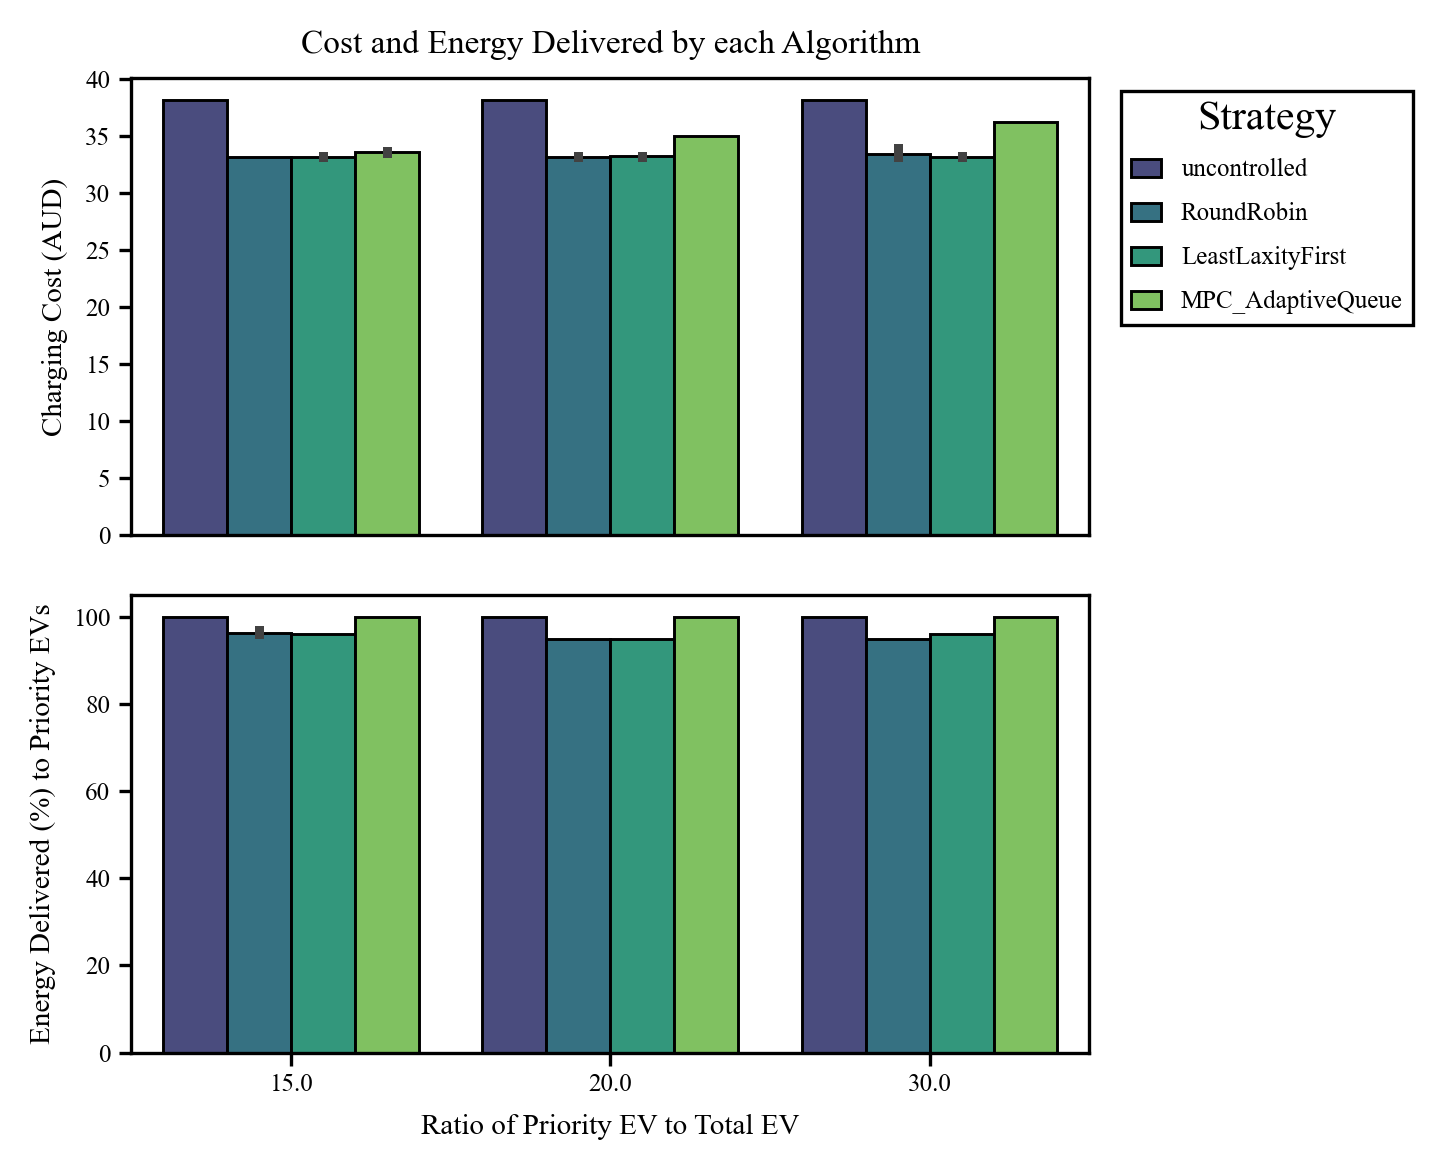

In [83]:
# Create the bar chart
# Adjust figure size: (width, height) in inches.
# Common single-column width is ~3.5 inches, double-column ~7 inches.
fig, axes = plt.subplots(2, 1, figsize=(3.5, 4), sharex=True) # 2 rows, 1 columm

# --- Plot 1: Charging Costs ---
sns.barplot(
    data=df_cost_melted,
    x='priority_ev_ratio', # Use the categorical version for distinct bars
    y='ChargingCost',
    hue='ChargingStrategy',
    palette='viridis', # Good for colorblindness and prints well in grayscale
    ax=axes[0],
    edgecolor='black', # Add edge color for better bar separation
    linewidth=0.7    # Linewidth for bar edges
)

axes[0].set_ylabel("Charging Cost (AUD)")
axes[0].set_title("Cost and Energy Delivered by each Algorithm") # Main title on the first plot
axes[0].xaxis.set_visible(False) # Remove the x-axis from the top subplot
axes[0].legend(title="Strategy", bbox_to_anchor=(1.02, 1), loc='upper left')

# --- Plot 2: Energy Delivered ---
sns.barplot(
    data=df_priority_ev_served_melted,
    x='priority_ev_ratio',
    y='priority_value',
    hue='charging_strategy',
    palette='viridis', # Use same palette for consistency
    ax=axes[1],
    edgecolor='black',
    linewidth=0.7
)
axes[1].set_ylabel("Energy Delivered (%) to Priority EVs")
axes[1].set_xlabel("Ratio of Priority EV to Total EV") # X-label only on the bottom plot
axes[1].tick_params(axis='x', rotation=0) # Apply rotation here
# axes[1].legend(title="Strategy", bbox_to_anchor=(1.02, 1), loc='upper left') # Add legend if needed, or rely on the top one

# To prevent legend overlap if both are shown and placed outside, or use a single figure legend
# For now, we show legend on the first plot and can hide it on the second if the hue is identical.
if axes[0].get_legend() is not None and axes[1].get_legend() is not None:
    axes[1].get_legend().remove() # Remove second legend if first one is sufficient
# axes[0].get_legend().remove() # Option: remove legend if using a single figure legend later

# Ensure everything fits and save
plt.tight_layout(rect=[0, 0, 1.4, 1]) # Adjust rect to make space for legend outside plot area if needed

# Save in multiple formats
file_basename = "C:\\Users\\s3955218\\OneDrive - RMIT University\\PhD Writing\\Journal\\Simualtion_results\charging_cost_comparison_12evse"
plt.savefig(f"{file_basename}.png", dpi=300, bbox_inches='tight')
# plt.savefig(f"{file_basename}.pdf", dpi=300, bbox_inches='tight')
# plt.savefig(f"{file_basename}.svg", bbox_inches='tight')
# print(f"Plot saved as {file_basename}.png, {file_basename}.pdf, and {file_basename}.svg")
print(f"Plot saved as {file_basename}.png")

plt.show()

# Print the modified melted dataframe to show its structure (optional)
# print("\nModified Melted DataFrame structure (first 5 rows):")
# print(df_melted.head())

In [4]:
df_tou = pd.read_csv('ToU.csv', header=None, names=['electricity_price'])
df_tou['electricity_price'] = (df_tou['electricity_price']/100).round(2) # Convert to cents and round to 2 decimal places
df_tou

,electricity_price
0,0.18
1,0.18
2,0.18
3,0.18
4,0.18
...,...
331,0.21
332,0.18
333,0.18
334,0.18


In [5]:
hours_per_datapoint = 24 / len(df_tou)
time_mapping = np.arange(len(df_tou)) * hours_per_datapoint

def create_time_labels_fractional(time_values):
    labels = []
    for t in time_values:
        hour = int(t)
        minute = int((t - hour) * 60)
        
        if hour == 0 and minute == 0:
            labels.append('12:00 AM')
        elif hour == 0:
            labels.append(f'12:{minute:02d} AM')
        elif hour < 12:
            if minute == 0:
                labels.append(f'{hour}:00 AM')
            else:
                labels.append(f'{hour}:{minute:02d} AM')
        elif hour == 12 and minute == 0:
            labels.append('12:00 PM')
        elif hour == 12:
            labels.append(f'12:{minute:02d} PM')
        else:
            if minute == 0:
                labels.append(f'{hour-12}:00 PM')
            else:
                labels.append(f'{hour-12}:{minute:02d} PM')
    return labels
    

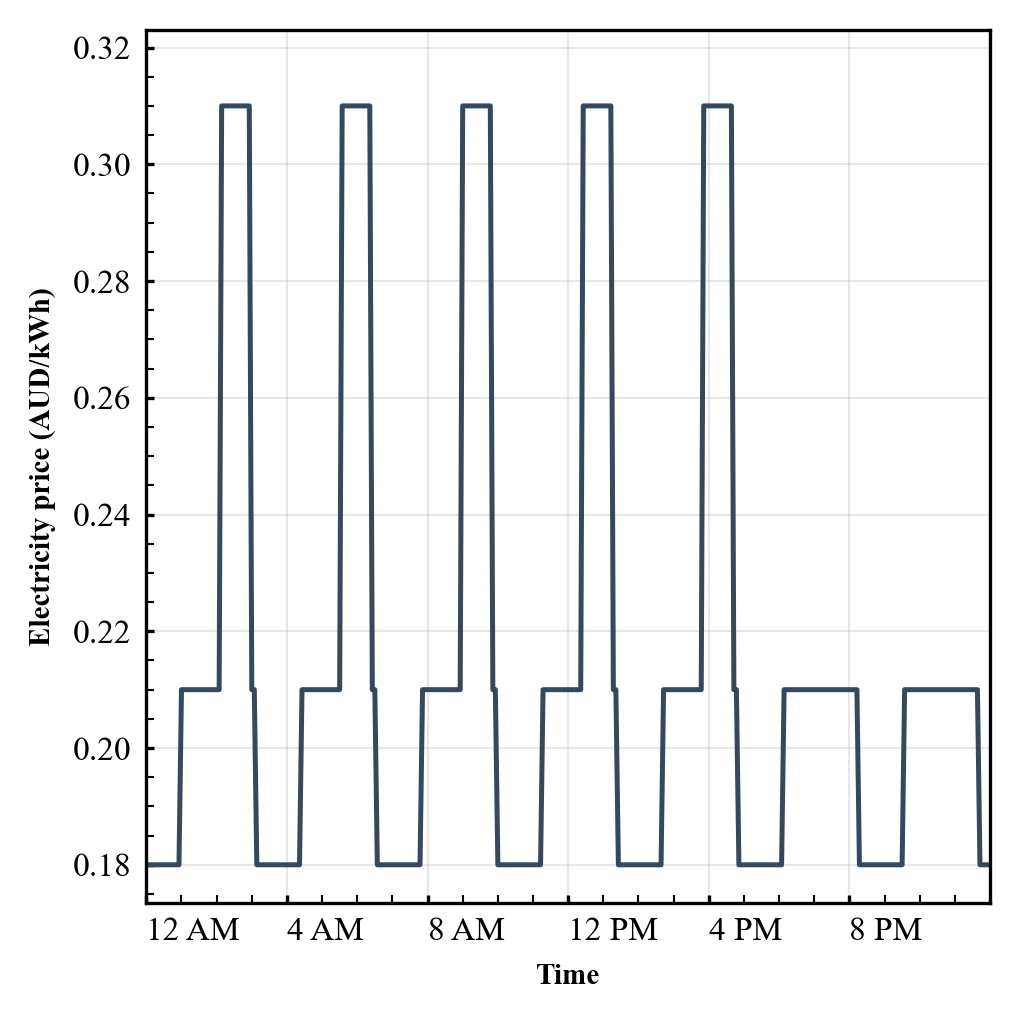

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=300)

sns.lineplot(data=df_tou, x=time_mapping, y='electricity_price', ax=ax, color='#34495E', linewidth=1.2)

ax.set_xlabel('Time', fontsize=7, fontweight='bold')
ax.set_ylabel('Electricity price (AUD/kWh)', fontsize=7, fontweight='bold')
# ax.set_title('Time of Use Data Pattern', fontsize=11, fontweight='bold', pad=10)

# Set custom x-axis ticks and labels (approximately every hour)
tick_positions = np.arange(0, 24, 4)  # Every 4 hours
tick_labels = []

for hour in tick_positions:
    if hour == 0:
        tick_labels.append('12 AM')
    elif hour < 12:
        tick_labels.append(f'{int(hour)} AM')
    elif hour == 12:
        tick_labels.append('12 PM')
    else:
        tick_labels.append(f'{int(hour-12)} PM')

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, ha='left', fontsize=7)

# Set x-axis limits to show full 24-hour range
# ax.set_xlim(0, 24)
ax.set_xlim(0, 24)

# Set grid
ax.grid(True, alpha=0.3, linewidth=0.5, linestyle='-')

# Set tick parameters
ax.tick_params(axis='both', which='major', labelsize=8, direction='in', 
               top=False, right=False, length=2, width=0.8)
ax.tick_params(axis='both', which='minor', direction='in',
               top=False, right=False, length=2, width=0.5)

# Enable minor ticks
ax.minorticks_on()

# Set y-axis limits with some padding
y_min, y_max = df_tou['electricity_price'].min(), df_tou['electricity_price'].max()
y_range = y_max - y_min
ax.set_ylim(y_min - 0.05*y_range, y_max + 0.10*y_range)
# ax.set_ylim(0.10, 0.35)
# ax.set_yticks(np.linspace(0.10, 0.35, 4))

# Tight layout to optimize space usage
plt.tight_layout()

# Save the figure with high quality settings for journal publication
plt.savefig("C:\\Users\\s3955218\\OneDrive - RMIT University\\PhD Writing\\Journal\\Simualtion_results\\electricity_price.png", dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none', format='png')
# plt.savefig('tou_data_plot.pdf', bbox_inches='tight', 
#             facecolor='white', edgecolor='none', format='pdf')

In [3]:
df = pd.read_csv('data_for_priority_ev.csv')
df.columns = df.columns.str.strip()

In [4]:
# Algorithm mapping for cleaner labels
algorithms = ['served (%) by Uncontrolled', 'served (%) by RR', 'served (%) by LLF', 'served (%) by MPC_AdaptiveQueue']
algorithm_names = ['Uncontrolled', 'RR', 'LLF', 'MPC-AQ']

# Color palette optimized for journal printing
colors = ['#2C3E50', '#34495E', '#7F8C8D', '#000000']
sns.set_palette(colors)

In [5]:
# Prepare data for seaborn visualizations
melted_df = pd.melt(df, id_vars=['Day', 'Time of the day', 'Number of priority Evs'],
                    value_vars=algorithms,
                    var_name='Algorithm', value_name='Service_Rate')

melted_df['Algorithm'] = melted_df['Algorithm'].map({
    'served (%) by Uncontrolled': 'Uncontrolled',
    'served (%) by RR': 'RR',
    'served (%) by LLF': 'LLF',
    'served (%) by MPC_AdaptiveQueue': 'MPC-AQ'
})

(94.0, 101.0)

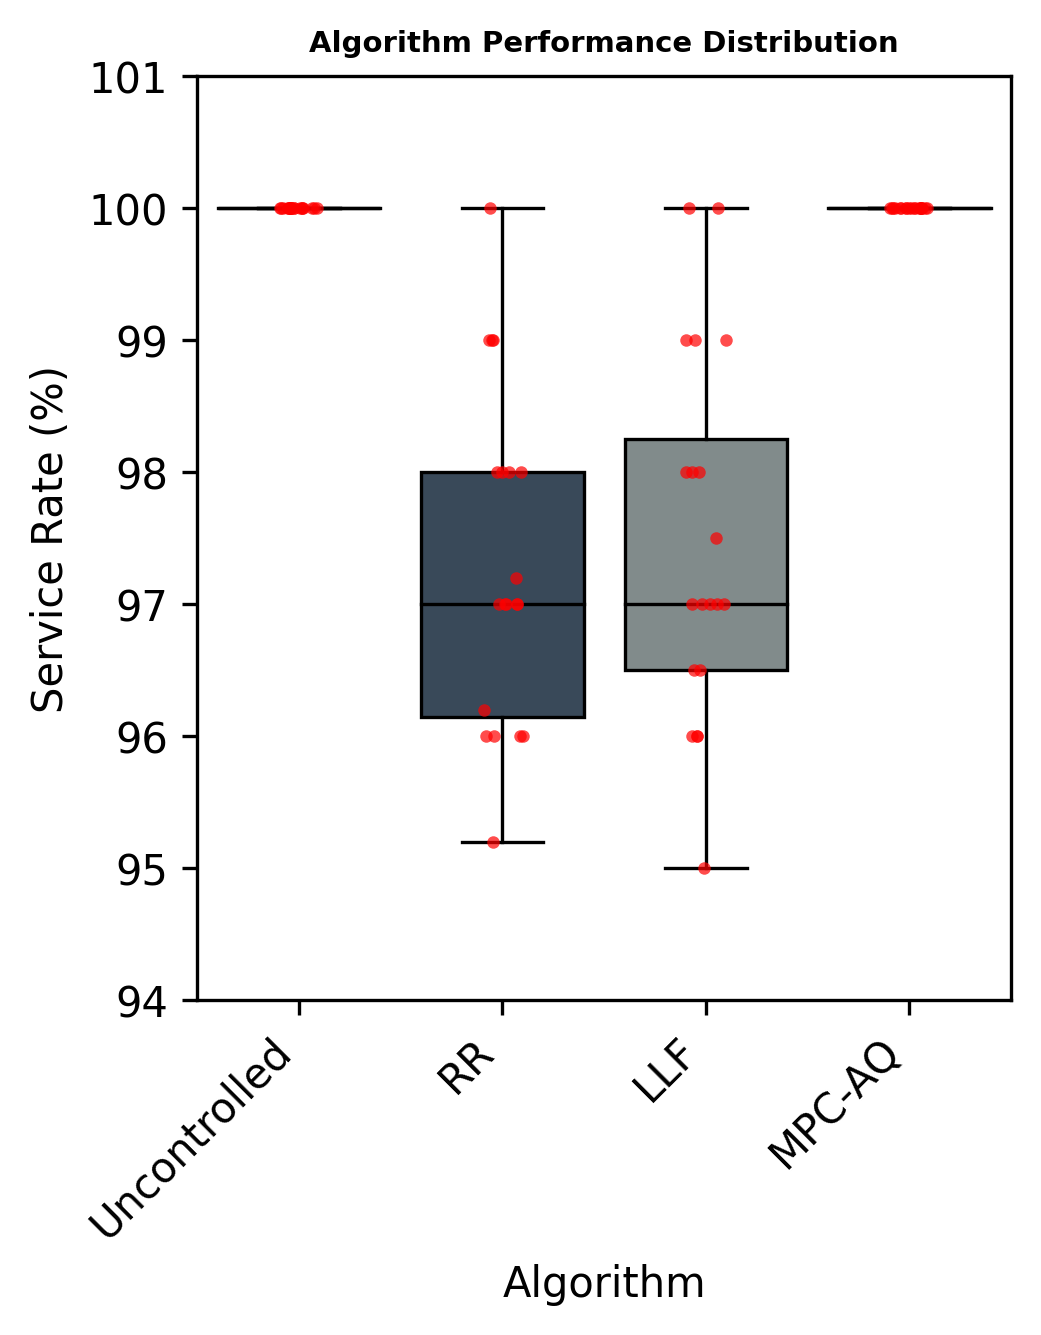

In [18]:
# Figure 1: Box plot using seaborn
fig, ax = plt.subplots(figsize=(3.5, 4), dpi=300)

sns.boxplot(data=melted_df, x='Algorithm', y='Service_Rate', 
            palette=colors, ax=ax, linewidth=0.8)

# Add mean markers
sns.stripplot(data=melted_df, x='Algorithm', y='Service_Rate', 
              color='red', size=3, alpha=0.7, ax=ax)

ax.set_xlabel('Algorithm')
ax.set_ylabel('Service Rate (%)')
ax.set_title('Algorithm Performance Distribution', weight='bold', fontsize=7)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylim(94, 101)

# plt.tight_layout()
# plt.savefig("C:\\Users\\s3955218\\OneDrive - RMIT University\\PhD Writing\\Journal\\Simualtion_results\\priority_ev_service_rate_boxplot.png", dpi=300, bbox_inches='tight', 
#             facecolor='white', edgecolor='none', format='png')
# plt.show()

(0.8, 5.2)

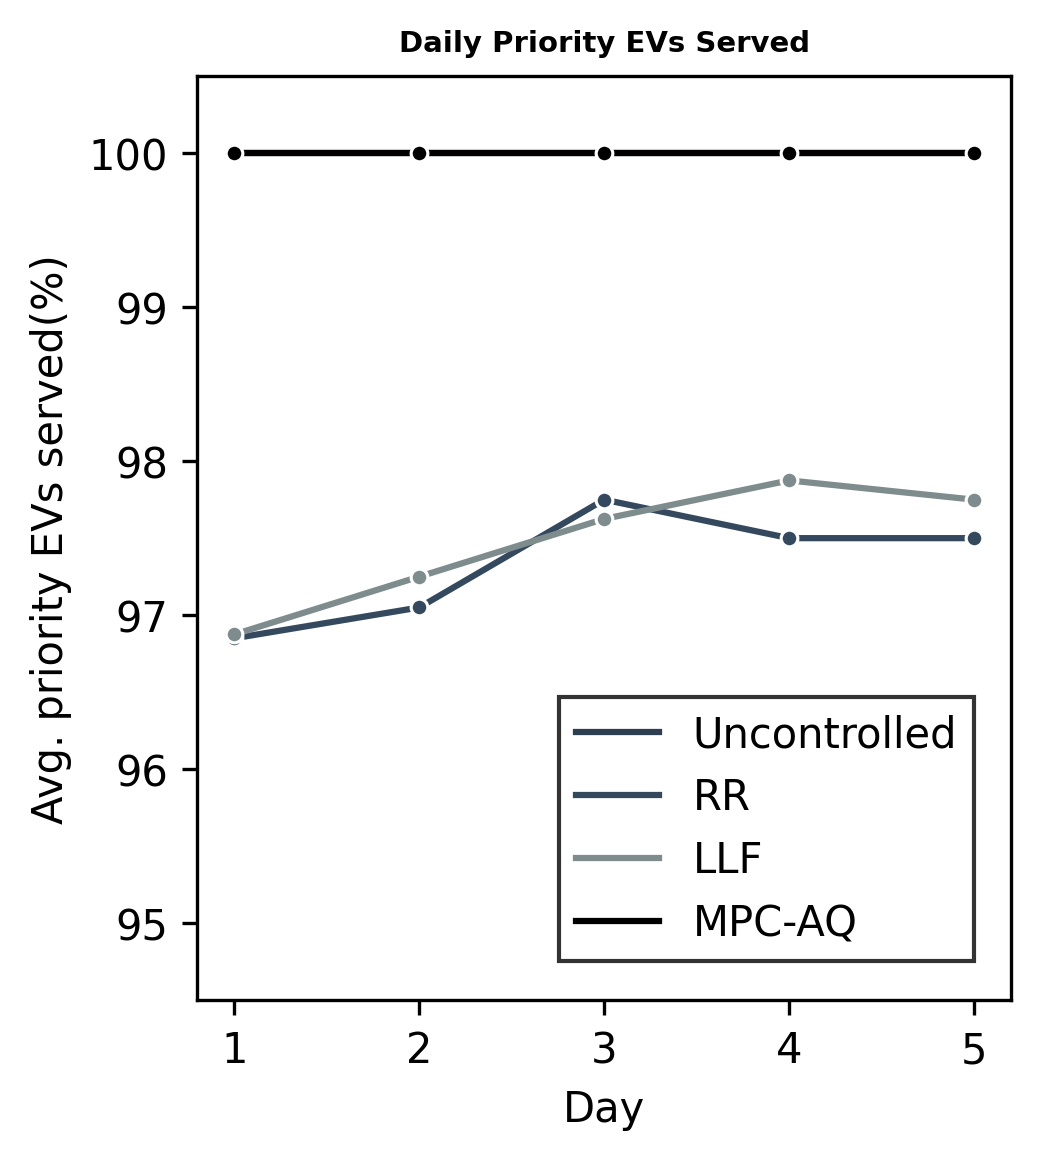

In [20]:
# Figure 2: Line plot
fig, ax = plt.subplots(figsize=(3.5, 4), dpi=300)

# Calculate daily averages
daily_avg = df.groupby('Day')[algorithms].mean().reset_index()
daily_melted = pd.melt(daily_avg, id_vars=['Day'], 
                       value_vars=algorithms,
                       var_name='Algorithm', value_name='Service_Rate')

daily_melted['Algorithm'] = daily_melted['Algorithm'].map({
    'served (%) by Uncontrolled': 'Uncontrolled',
    'served (%) by RR': 'RR',
    'served (%) by LLF': 'LLF',
    'served (%) by MPC_AdaptiveQueue': 'MPC-AQ'
})

sns.lineplot(data=daily_melted, x='Day', y='Service_Rate', 
             hue='Algorithm', marker='o', linewidth=1.5, 
             markersize=4, ax=ax, palette=colors)

ax.set_xlabel('Day')
ax.set_ylabel('Avg. priority EVs served(%)')
ax.set_title('Daily Priority EVs Served', weight='bold', fontsize=7)
ax.legend(frameon=True, fancybox=False, edgecolor='black', 
          loc='lower right', bbox_to_anchor=(0.98, 0.02))
ax.set_ylim(94.5, 100.5)
ax.set_xlim(0.8, 5.2)

# plt.tight_layout()
# plt.savefig("C:\\Users\\s3955218\\OneDrive - RMIT University\\PhD Writing\\Journal\\Simualtion_results\\priority_ev_service_rate_daily.png", dpi=300, bbox_inches='tight', 
#             facecolor='white', edgecolor='none', format='png')
# plt.show()

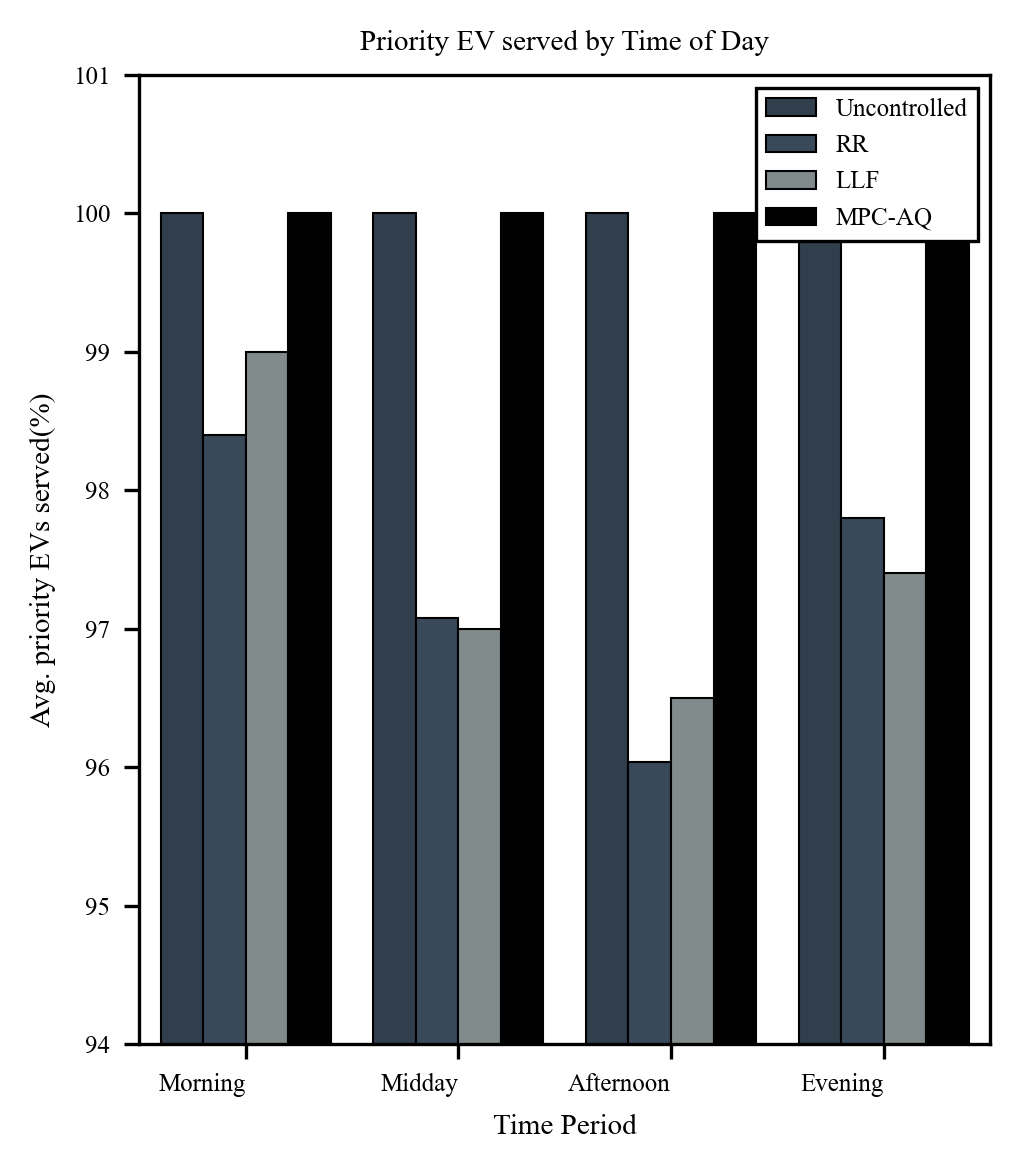

In [19]:
# Figure 3: Bar plot using seaborn
fig, ax = plt.subplots(figsize=(3.5, 4), dpi=300)

# Prepare data for time-based comparison
time_avg = df.groupby('Time of the day')[algorithms].mean().reset_index()
time_melted = pd.melt(time_avg, id_vars=['Time of the day'], 
                      value_vars=algorithms,
                      var_name='Algorithm', value_name='Service_Rate')

time_melted['Algorithm'] = time_melted['Algorithm'].map({
    'served (%) by Uncontrolled': 'Uncontrolled',
    'served (%) by RR': 'RR',
    'served (%) by LLF': 'LLF',
    'served (%) by MPC_AdaptiveQueue': 'MPC-AQ'
})

# Simplify time labels
time_label_map = {
    '7:00 AM - 9:59 AM': 'Morning',
    '10:00 AM - 12:59 PM': 'Midday', 
    '1:00 PM - 3:59 PM': 'Afternoon',
    '4:00 PM - 7:00 PM': 'Evening'
}
time_melted['Time_Simple'] = time_melted['Time of the day'].map(time_label_map)

# Define the correct order for time periods
time_order = ['Morning', 'Midday', 'Afternoon', 'Evening']

sns.barplot(data=time_melted, x='Time_Simple', y='Service_Rate', 
            hue='Algorithm', palette=colors, ax=ax, 
            edgecolor='black', linewidth=0.5, order=time_order)

ax.set_xlabel('Time Period', fontsize=7, fontdict={'fontsize': 7, 'fontweight': 'normal'})
ax.set_ylabel('Avg. priority EVs served(%)', fontdict={'fontsize': 7, 'fontweight': 'normal'})
ax.set_title('Priority EV served by Time of Day', weight='normal', fontsize=7)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right', fontsize=6)
ax.tick_params(axis='y', labelsize=6)
# ax.legend(frameon=True, fancybox=False, edgecolor='black', ncol=1,
#           loc='upper left', bbox_to_anchor=(1.02, 1))
ax.legend(frameon=True, fancybox=False, edgecolor='black', 
          fontsize=6, loc='upper right')
ax.set_ylim(94, 101)

plt.tight_layout()
plt.savefig("C:\\Users\\s3955218\\OneDrive - RMIT University\\PhD Writing\\Journal\\Simualtion_results\\priority_ev_served_by_time_of_day.png", dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none', format='png')
plt.show()

(94.0, 101.0)

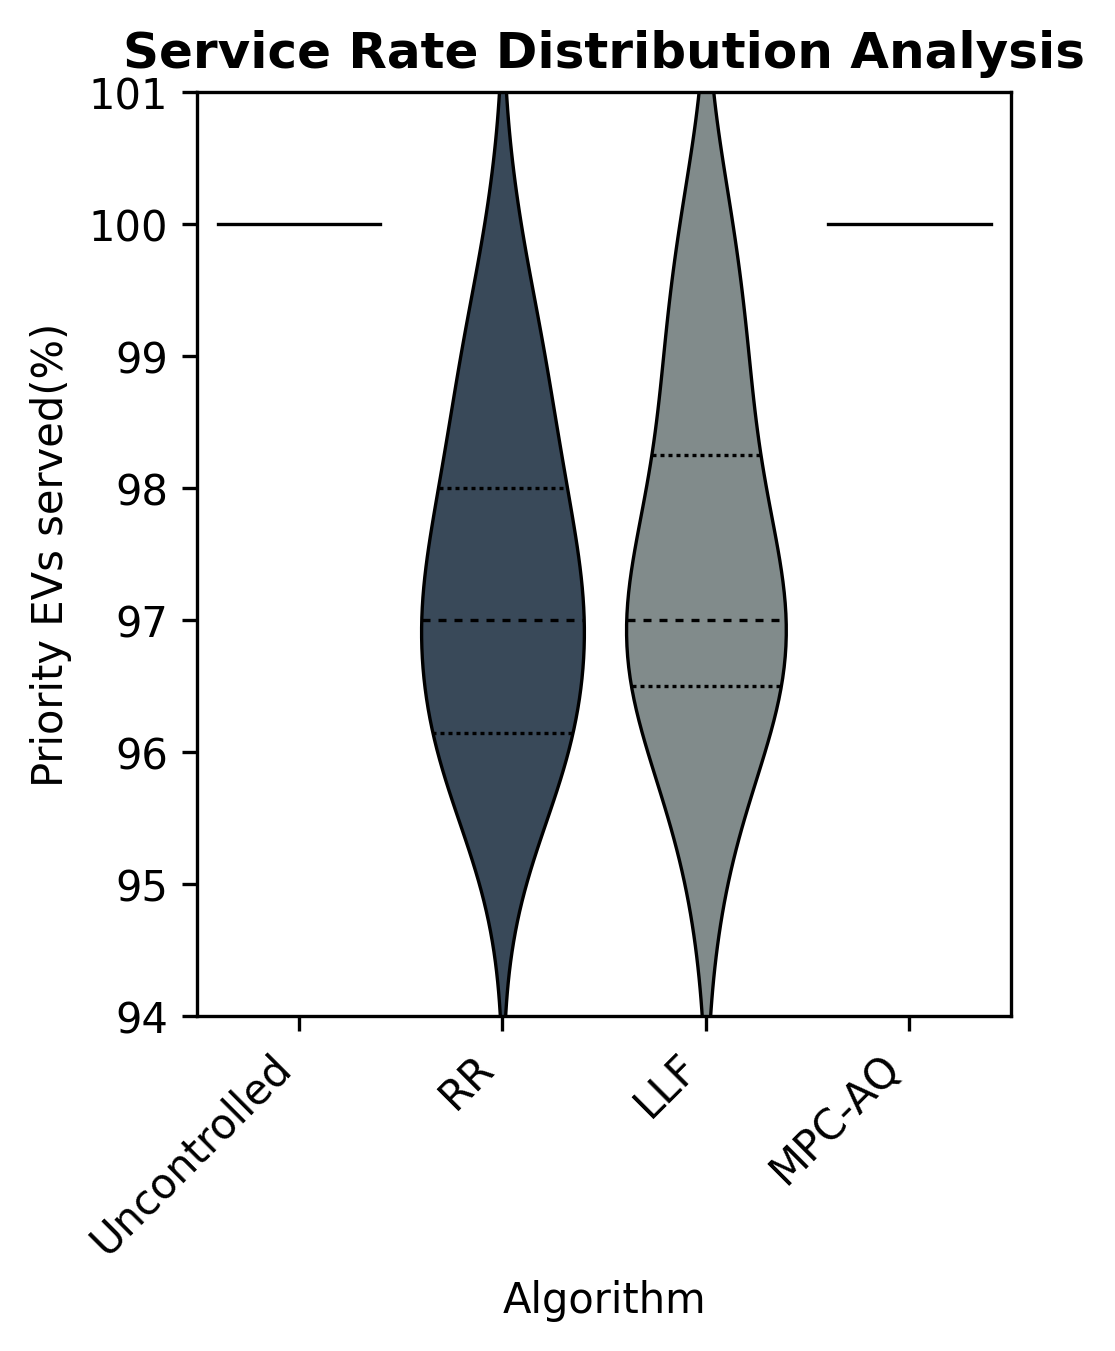

In [24]:
# Figure 4: Violin plot
fig, ax = plt.subplots(figsize=(3.5, 4), dpi=300)

sns.violinplot(data=melted_df, x='Algorithm', y='Service_Rate', 
               palette=colors, ax=ax, inner='quart', linewidth=0.8)

ax.set_xlabel('Algorithm')
ax.set_ylabel('Priority EVs served(%)')
ax.set_title('Service Rate Distribution Analysis', weight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylim(94, 101)

# plt.tight_layout()
# plt.savefig("C:\\Users\\s3955218\\OneDrive - RMIT University\\PhD Writing\\Journal\\Simualtion_results\\priority_ev_service_rate_violin.png", dpi=300, bbox_inches='tight',
#             facecolor='white', edgecolor='none', format='png')
# plt.show()

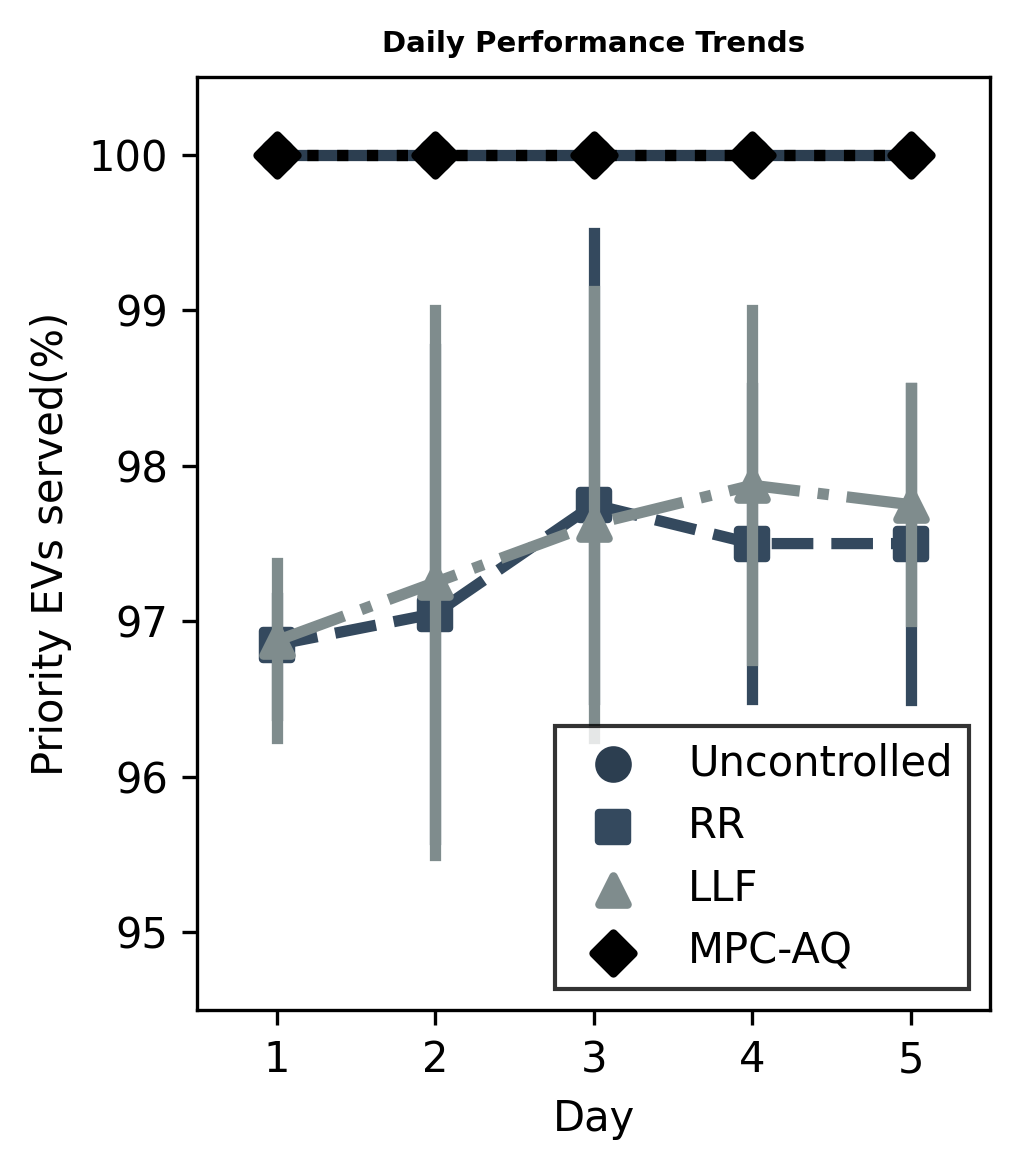

In [26]:
# Figure 6: Point plot for trend analysis
fig, ax = plt.subplots(figsize=(3.5, 4), dpi=300)

sns.pointplot(data=melted_df, x='Day', y='Service_Rate', 
              hue='Algorithm', palette=colors, ax=ax,
              markers=['o', 's', '^', 'D'], linestyles=['-', '--', '-.', ':'])

ax.set_xlabel('Day')
ax.set_ylabel('Priority EVs served(%)')
ax.set_title('Daily Performance Trends', weight='bold', fontsize=7)
ax.legend(frameon=True, fancybox=False, edgecolor='black',
          loc='lower right')
ax.set_ylim(94.5, 100.5)

plt.tight_layout()
plt.savefig("C:\\Users\\s3955218\\OneDrive - RMIT University\\PhD Writing\\Journal\\Simualtion_results\\priority_ev_service_rate_trend.png", dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none', format='png')
plt.show()

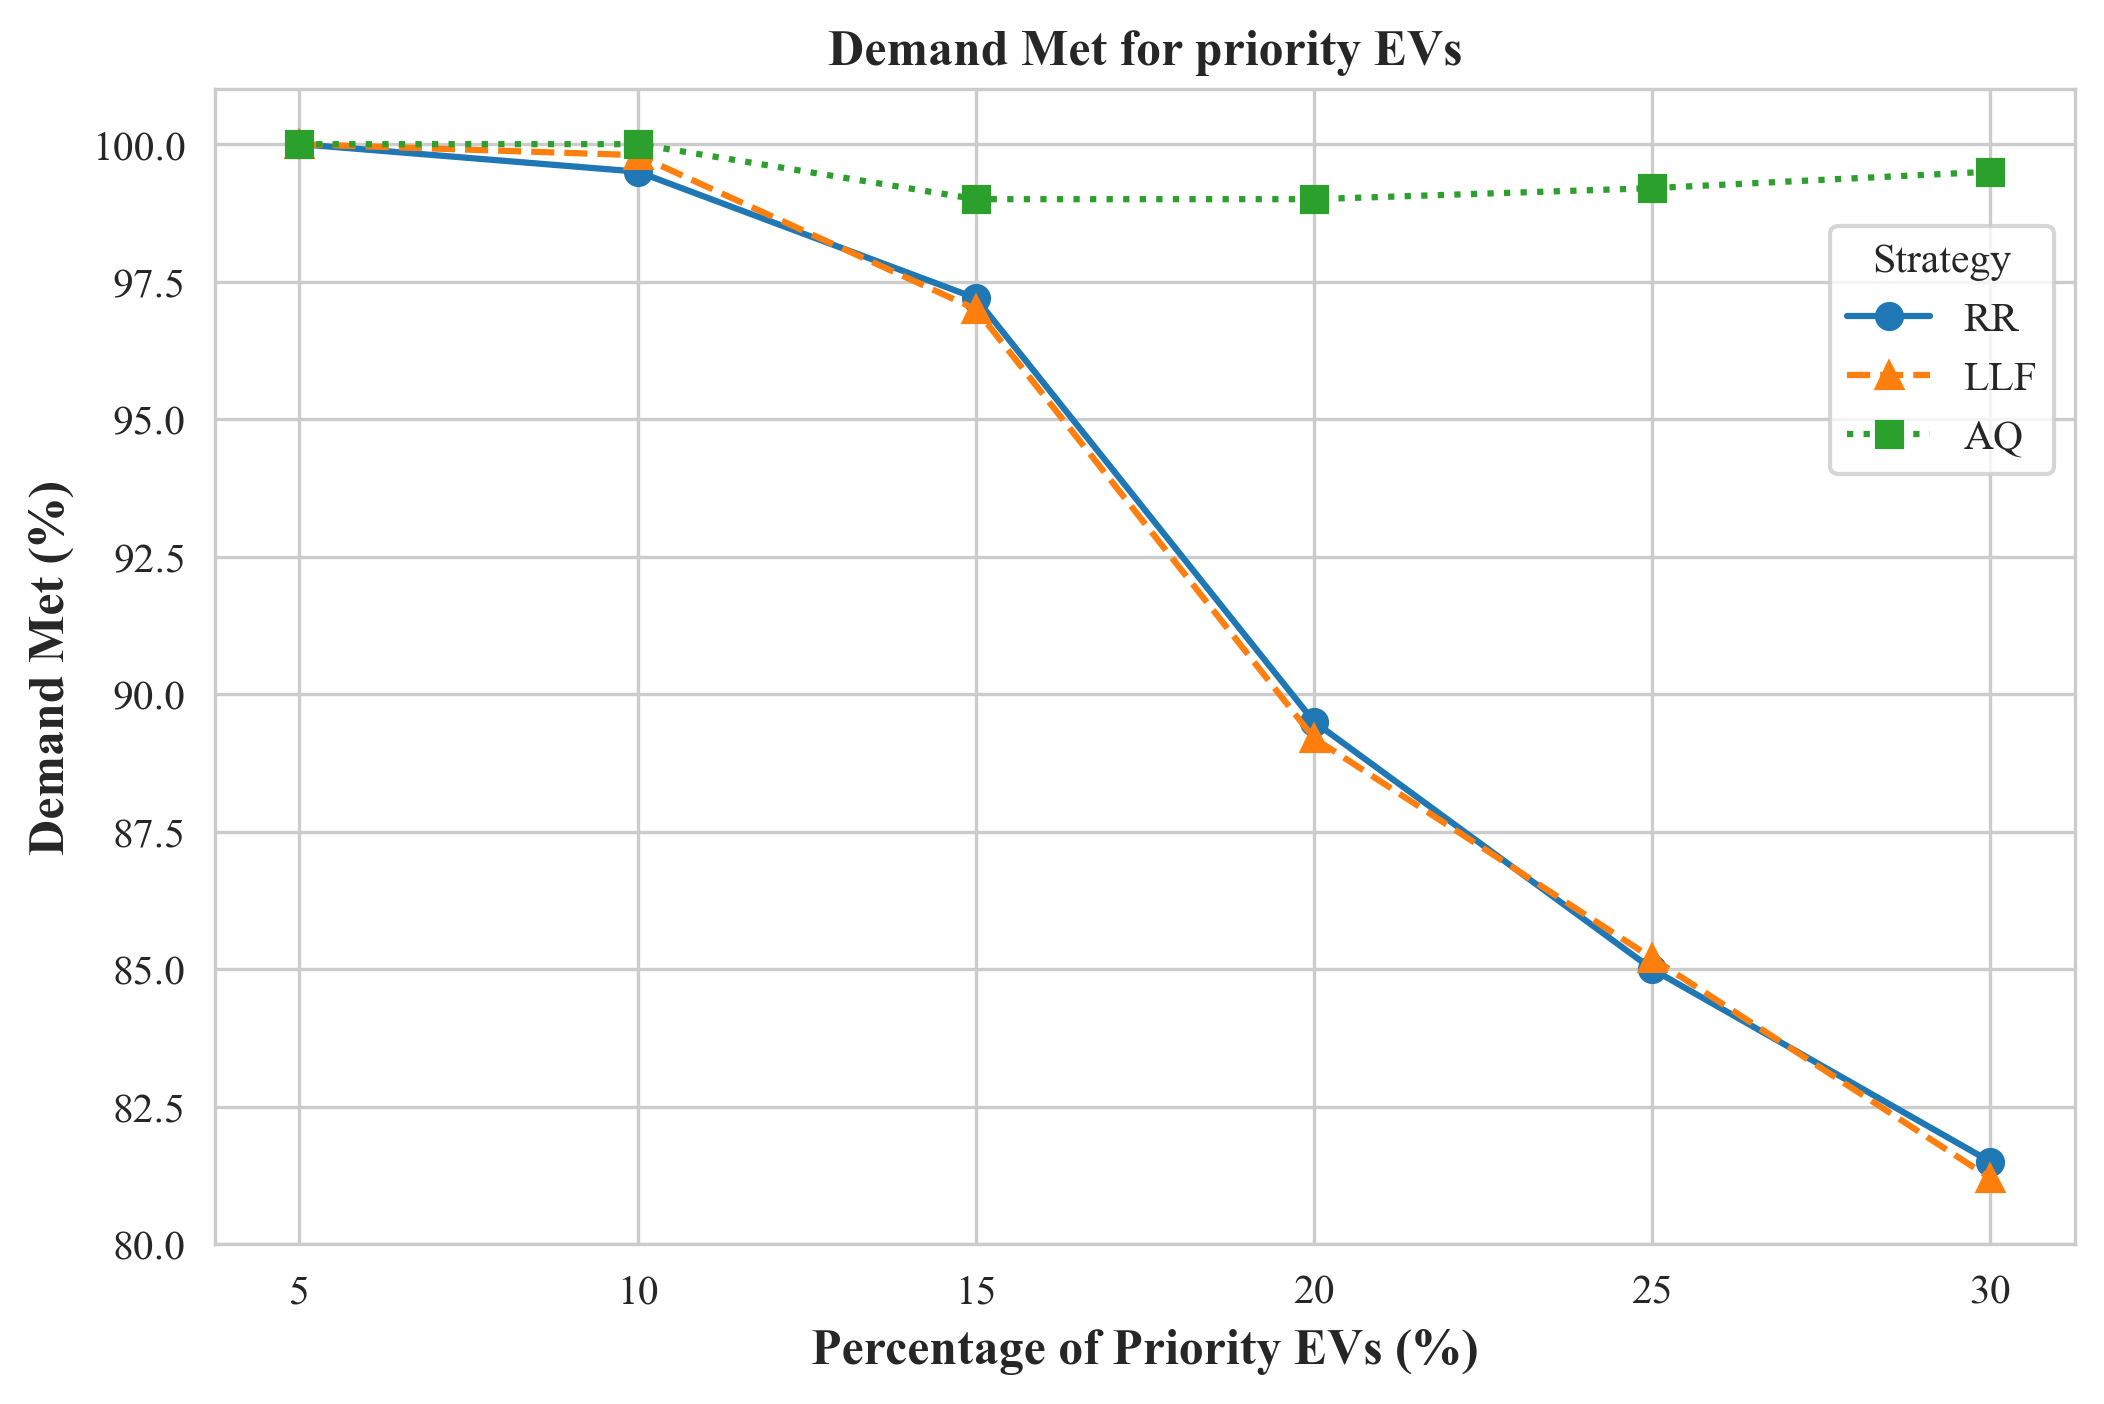

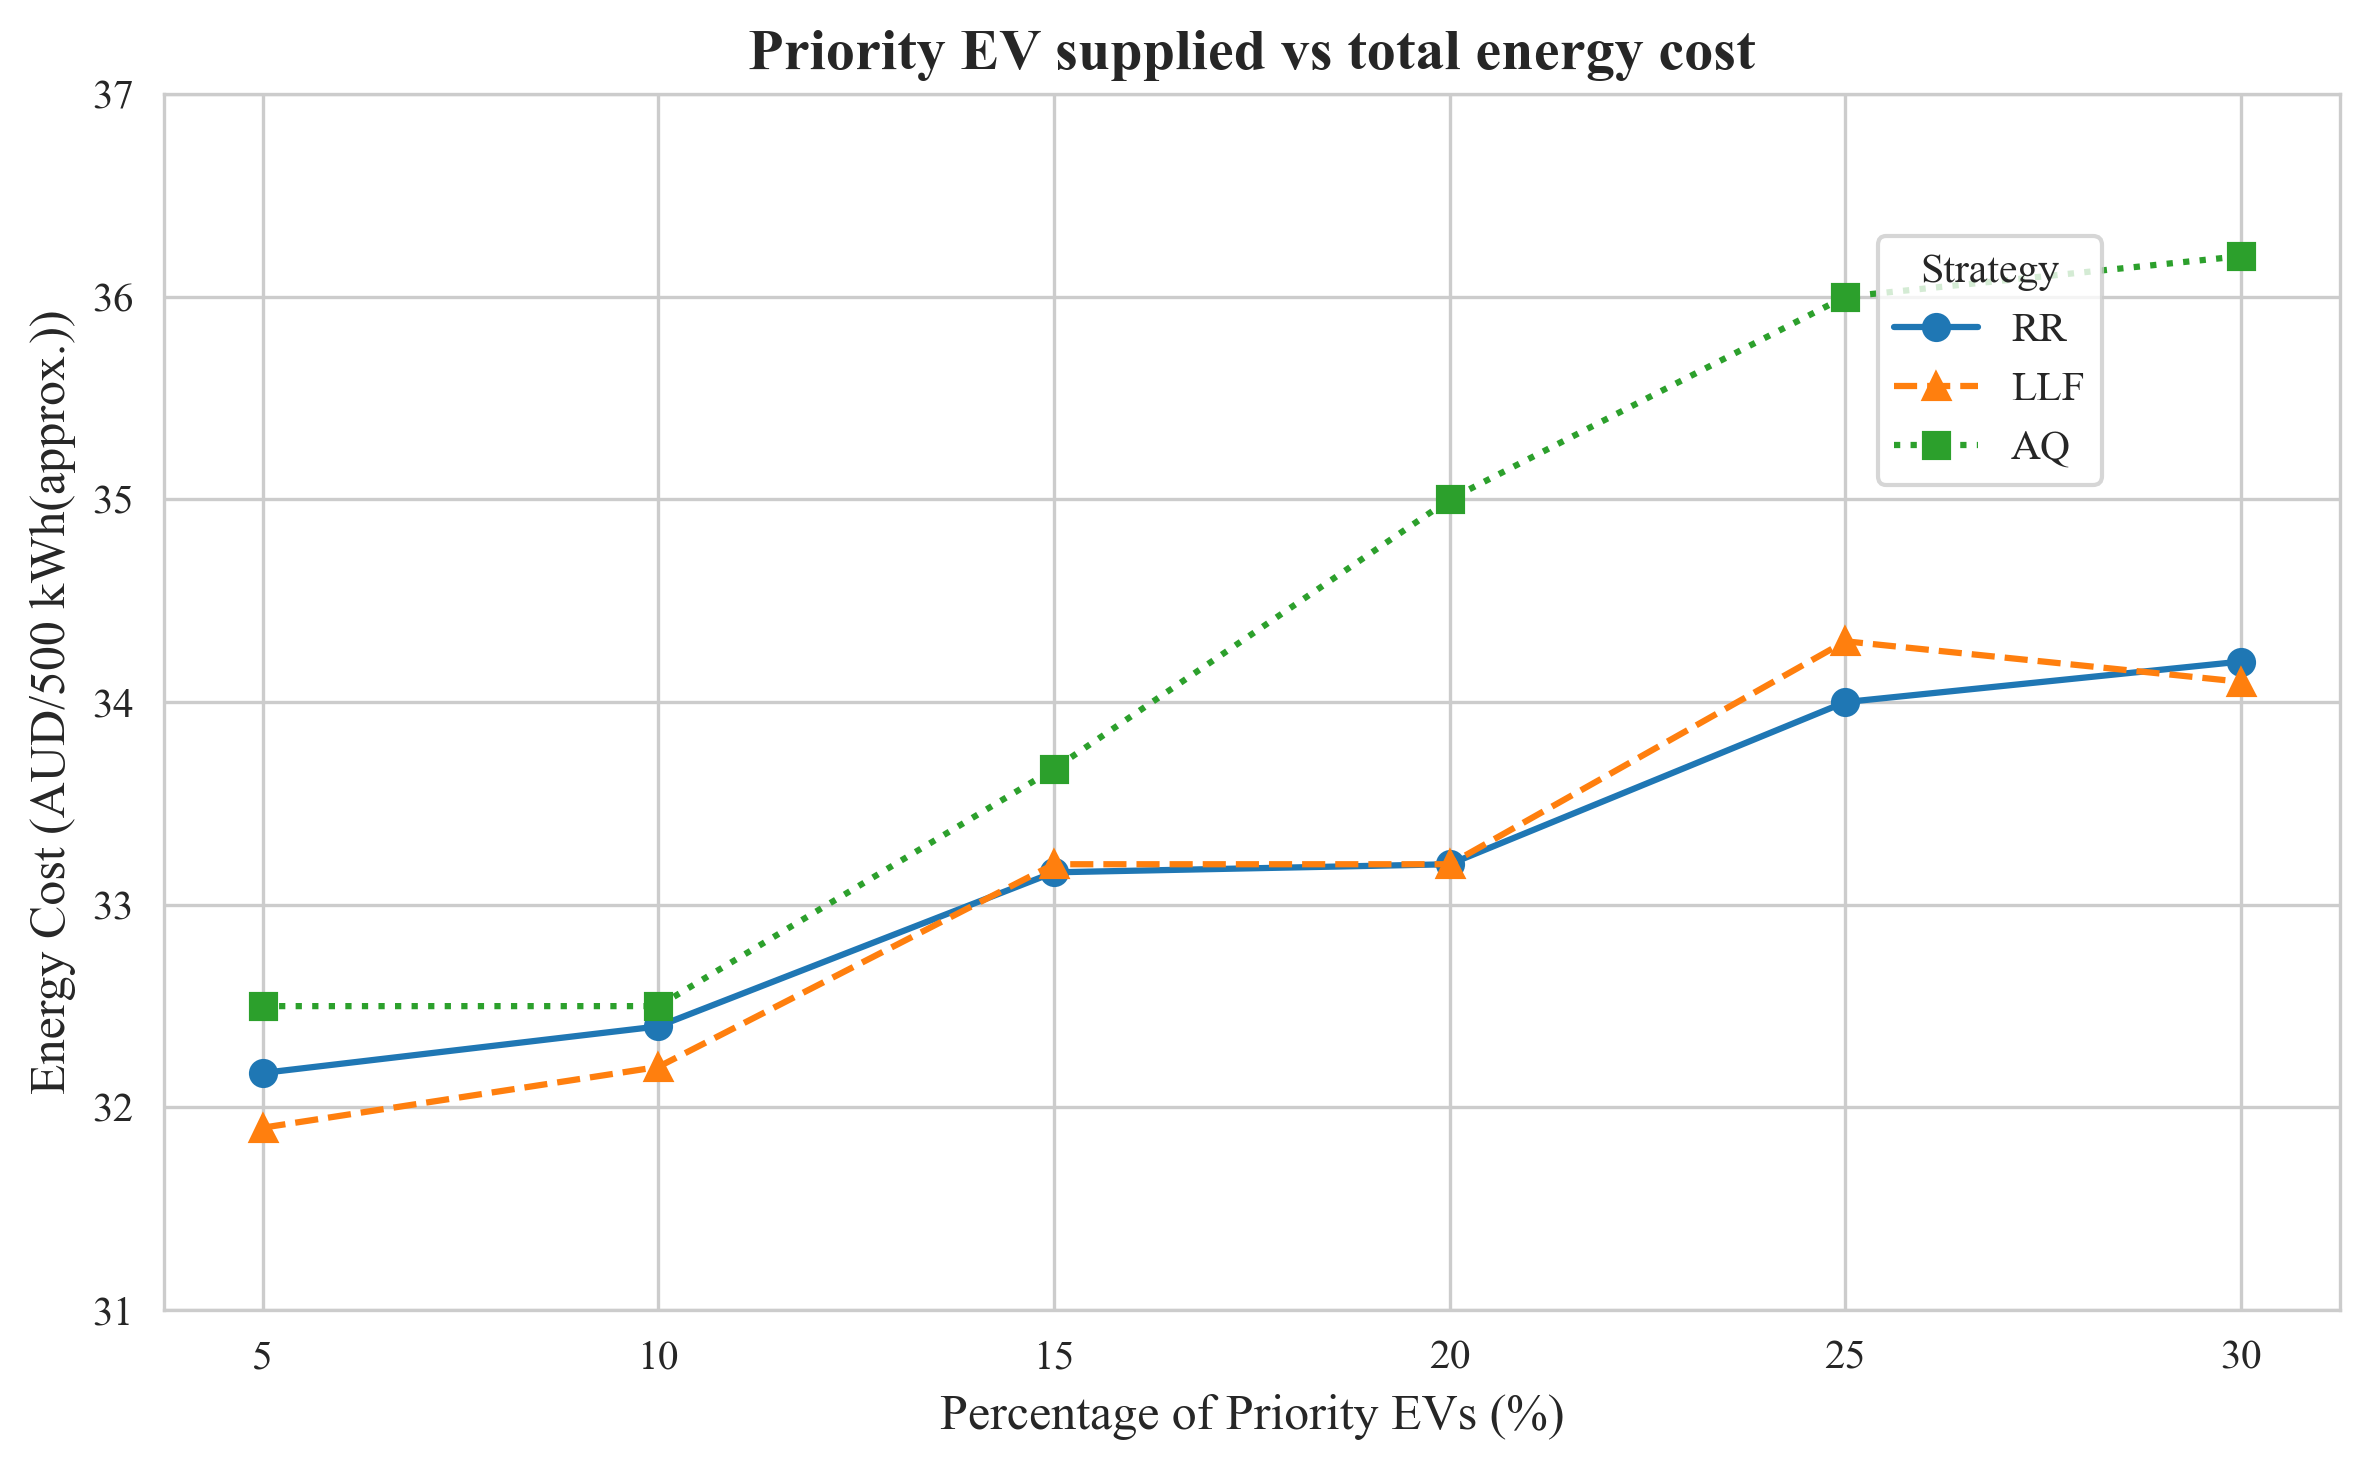

In [18]:
# --- Data Preparation ---

# Data for the first plot: Demand Met
demand_data = {
    'priority_ev (%)': [5, 10, 15, 20, 25, 30],
    'RR': [100, 99.5, 97.2, 89.5, 85, 81.5],
    'LLF': [100, 99.8, 97, 89.2, 85.2, 81.2],
    'AQ': [100, 100, 99, 99, 99.2, 99.5]
}
df_demand = pd.DataFrame(demand_data)

# Data for the second plot: Energy Cost
energy_data = {
    'priority_ev (%)': [5, 10, 15, 20, 25, 30],
    'RR': [32.17, 32.4, 33.16, 33.2, 34, 34.2],
    'LLR': [31.9, 32.2, 33.2, 33.2, 34.3, 34.1],
    'AQ': [32.5, 32.5, 33.67, 35, 36, 36.2]
}

df_energy = pd.DataFrame(energy_data)

# --- Plotting Configuration ---
# Set a professional style for the plots.
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Define markers and line styles for clarity.
markers = ['o', '^', 's']
linestyles = ['-', '--', ':']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Blue, Orange, Green

# --- Plot 1: Demand Met Analysis ---
fig1, ax1 = plt.subplots(figsize=(8, 5), dpi=300)

for i, column in enumerate(df_demand.columns[1:]):
    ax1.plot(df_demand['priority_ev (%)'], df_demand[column],
             marker=markers[i],
             linestyle=linestyles[i],
             color=colors[i],
             label=column)

# Set titles and labels for the first plot.
ax1.set_title('Demand Met for priority EVs', fontsize=12, fontweight='bold')
ax1.set_xlabel('Percentage of Priority EVs (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Demand Met (%)', fontsize=12, fontweight='bold')
ax1.set_ylim(80, 101) # Adjust y-axis for better spacing
ax1.set_xticks(df_demand['priority_ev (%)']) # Ensure all x-ticks are shown
ax1.legend(title='Strategy', fontsize=10, loc='upper right', bbox_to_anchor=(1, 0.9))

# --- Plot 2: Energy Cost Analysis ---
fig2, ax2 = plt.subplots(figsize=(8, 5), dpi=300)

for i, column in enumerate(df_energy.columns[1:]):
    # Rename 'LLR' to 'LLF' for consistency in the legend if desired, matching the first graph's likely intent.
    label_name = 'LLF' if column == 'LLR' else column
    ax2.plot(df_energy['priority_ev (%)'], df_energy[column],
             marker=markers[i],
             linestyle=linestyles[i],
             color=colors[i],
             label=label_name)

# Set titles and labels for the second plot.
ax2.set_title('Priority EV supplied vs total energy cost', fontsize=14, fontweight='bold')
ax2.set_xlabel('Percentage of Priority EVs (%)', fontsize=12)
ax2.set_ylabel('Energy Cost (AUD/500 kWh(approx.))', fontsize=12)
ax2.set_ylim(31, 37) # Adjust y-axis for better spacing
ax2.set_xticks(df_energy['priority_ev (%)']) # Ensure all x-ticks are shown
ax2.legend(title='Strategy', fontsize=10, loc='upper right', bbox_to_anchor=(0.9, 0.9))


# --- Display and Save Plots ---
# Show the plots.
plt.tight_layout()
plt.show()

# Save the figures to files.
# fig1.savefig('demand_met_analysis.png', bbox_inches='tight')
# fig2.savefig('energy_cost_analysis.png', bbox_inches='tight')

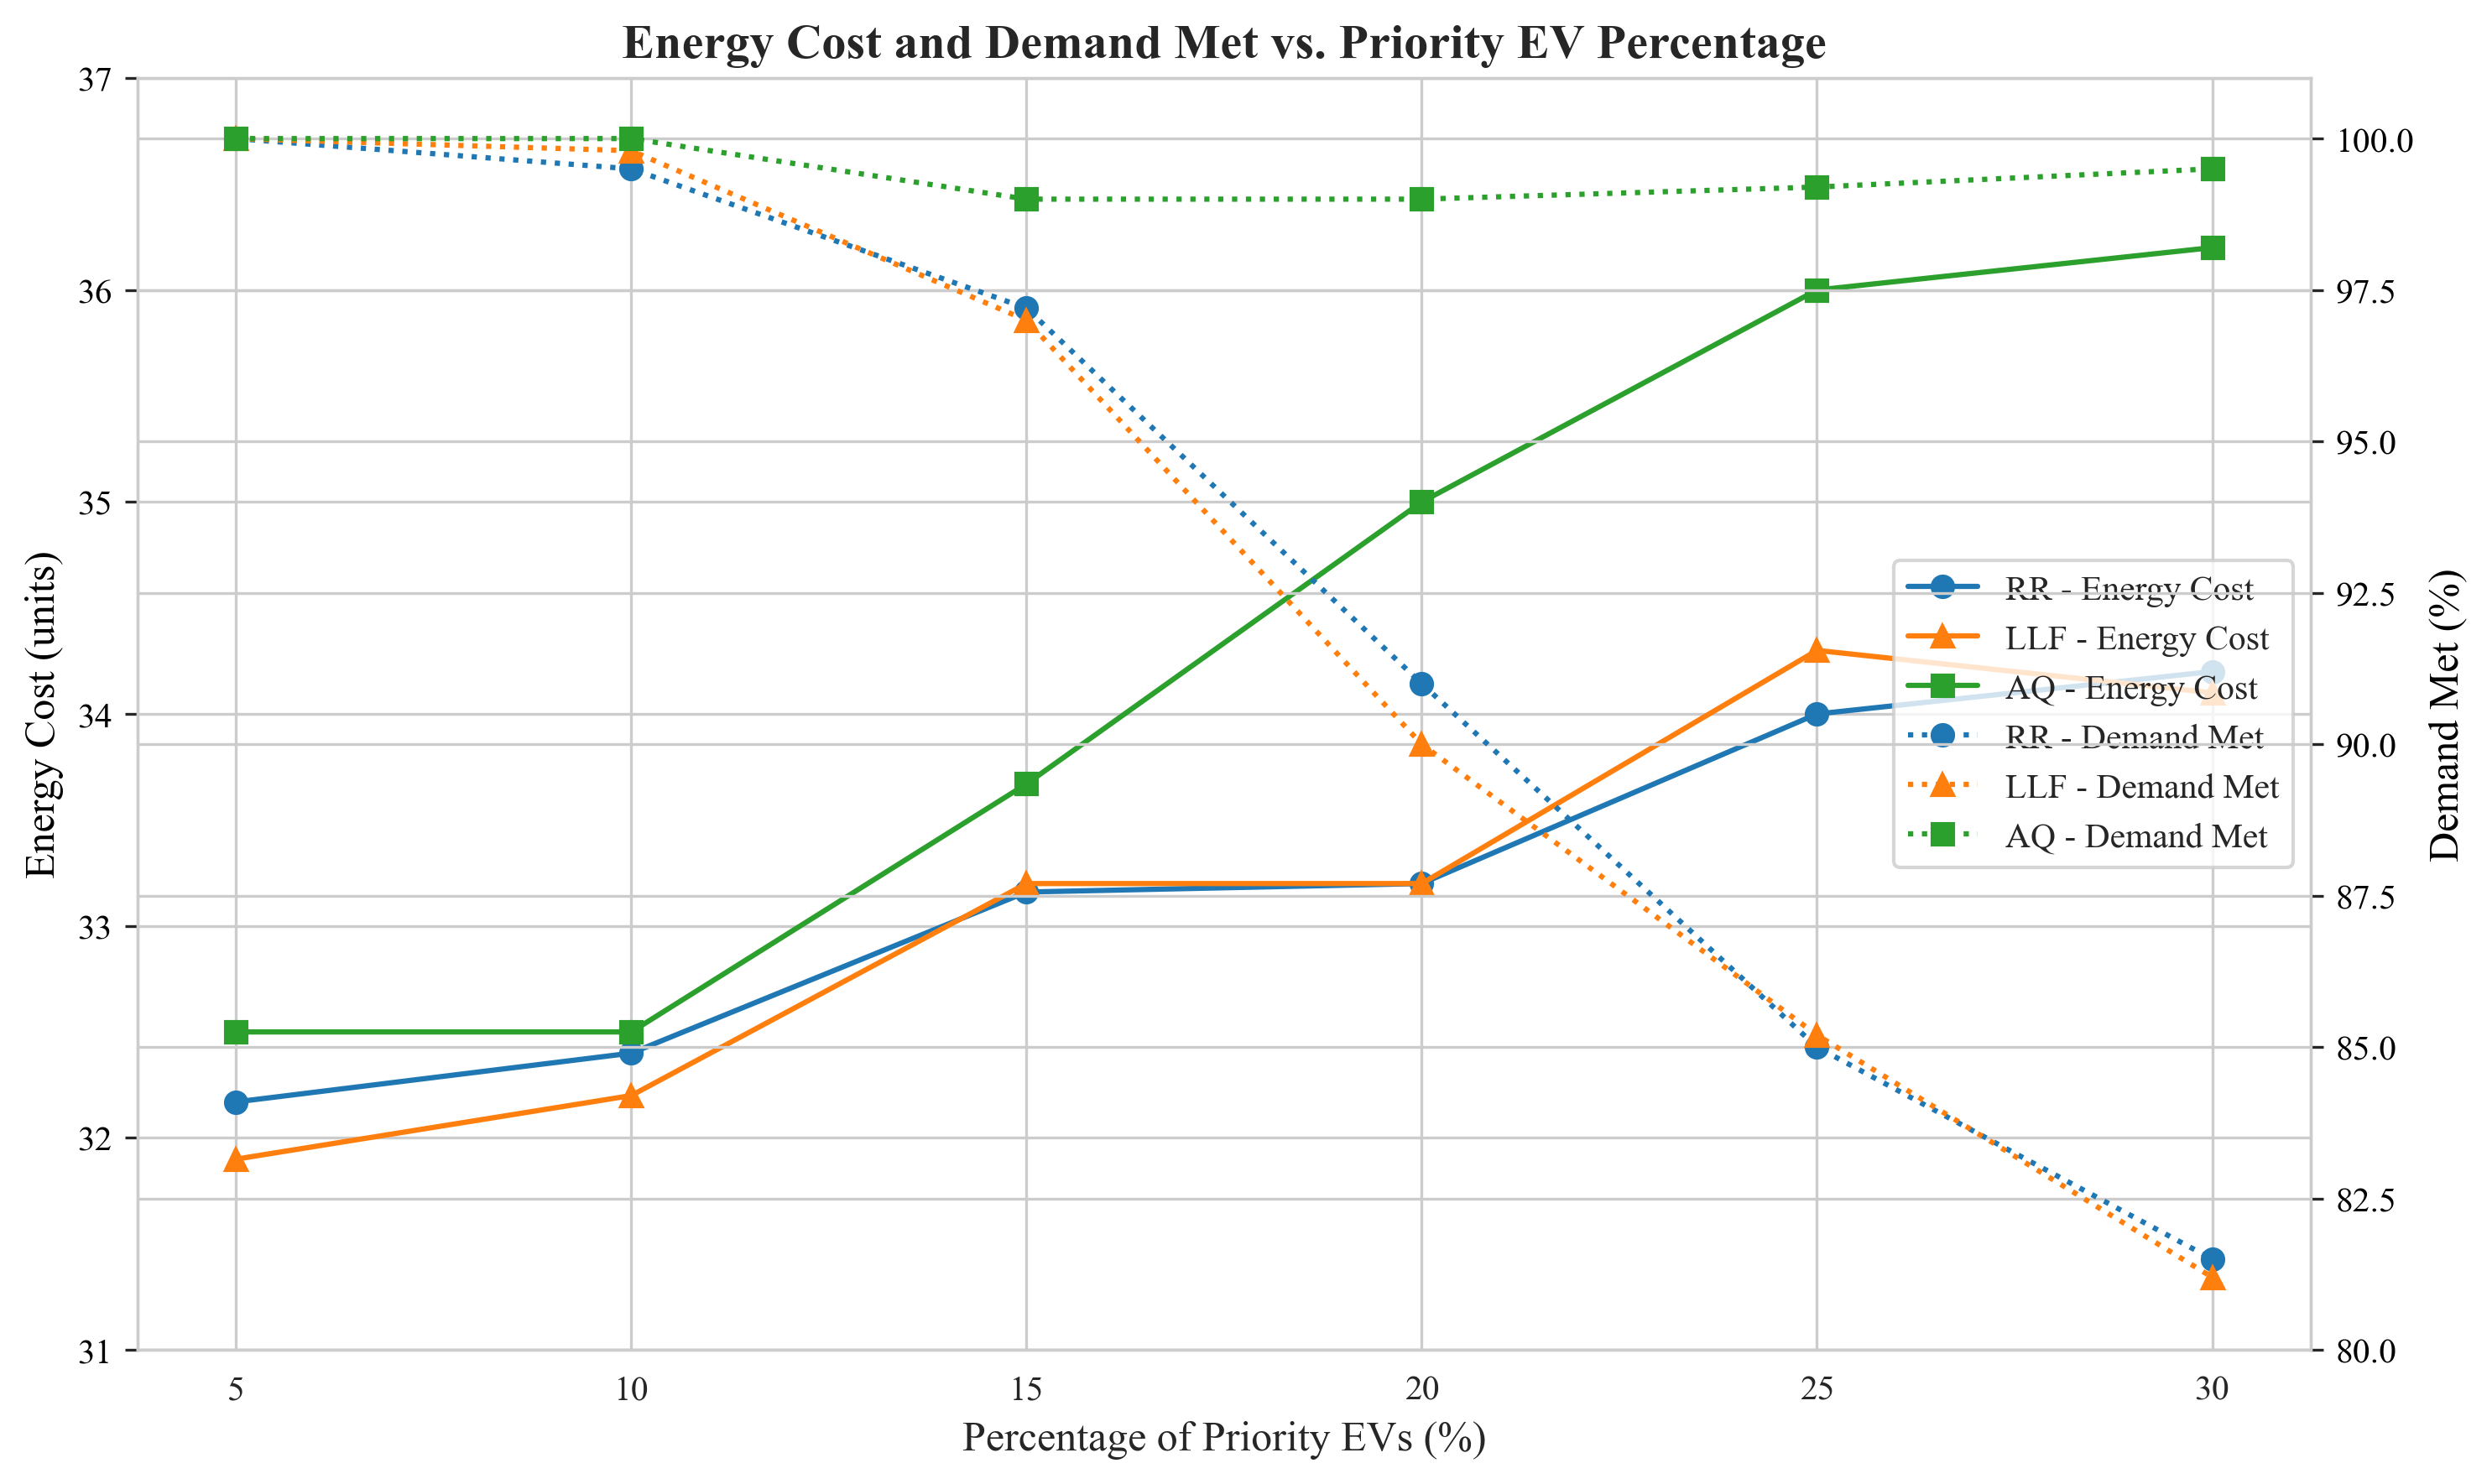

In [ ]:
# --- Data Preparation ---
demand_data = {
    'priority_ev (%)': [5, 10, 15, 20, 25, 30],
    'RR': [100, 99.5, 97.2, 91, 85, 81.5],
    'LLF': [100, 99.8, 97, 90, 85.2, 81.2],
    'AQ': [100, 100, 99, 99, 99.2, 99.5]
}
df_demand = pd.DataFrame(demand_data)

energy_data = {
    'priority_ev (%)': [5, 10, 15, 20, 25, 30],
    'RR': [32.17, 32.4, 33.16, 33.2, 34, 34.2],
    'LLR': [31.9, 32.2, 33.2, 33.2, 34.3, 34.1],
    'AQ': [32.5, 32.5, 33.67, 35, 36, 36.2]
}
df_energy = pd.DataFrame(energy_data)

# --- Plotting Configuration ---
# Set a professional style for the plots.
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Blue, Orange, Green for RR, LLF, AQ
markers = ['o', '^', 's']
# Use different linestyles for each metric to ensure clarity
energy_linestyles = ['-', '-', '-'] # Solid lines for Energy Cost
demand_linestyles = [':', ':', ':'] # Dotted lines for Demand Met

# --- Combined Double-Axis Plot ---
fig, ax1 = plt.subplots(figsize=(8, 5), dpi=300)

# Set the main title and x-axis label
ax1.set_title('Energy Cost and Demand Met vs. Priority EV Percentage', fontsize=14, fontweight='bold')
ax1.set_xlabel('Percentage of Priority EVs (%)', fontsize=12)
ax1.set_xticks(df_energy['priority_ev (%)'])

# Create the second Y-axis for Demand Met, sharing the x-axis
ax2 = ax1.twinx()

# Plot 1: Energy Cost on the primary Y-axis (ax1)
ax1.set_ylabel('Energy Cost (units)', fontsize=12, color='black')
for i, column in enumerate(df_energy.columns[1:]):
    # Rename 'LLR' to 'LLF' for consistency in the legend
    label_name = 'LLF' if column == 'LLR' else column
    ax1.plot(df_energy['priority_ev (%)'], df_energy[column],
             color=colors[i],
             marker=markers[i],
             linestyle=energy_linestyles[i],
             label=f'{label_name} - Energy Cost')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(31, 37)

# Plot 2: Demand Met on the secondary Y-axis (ax2)
ax2.set_ylabel('Demand Met (%)', fontsize=12, color='black')
for i, column in enumerate(df_demand.columns[1:]):
    ax2.plot(df_demand['priority_ev (%)'], df_demand[column],
             color=colors[i],
             marker=markers[i],
             linestyle=demand_linestyles[i],
             label=f'{column} - Demand Met')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(80, 101)

# --- Combined Legend ---
# Get handles and labels from both axes to create a single, unified legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

# Adjust layout to make room for all elements and prevent labels from overlapping
fig.tight_layout()

# Save the figure to a file
fig.savefig('combined_dual_axis_plot.png', bbox_inches='tight')

In [ ]:
# Data preparation
data = {
    'Timeofday': ['8:00 AM - 10:59 AM', '11:00 AM - 1:00 PM', '2:00 PM - 4:59 PM', '5:00 PM - 7:00 PM'],
    'RequestedEnergy': [100, 150, 120, 80, 50],
    'DeliveredByRR': [74.4, 111.6, 89.28, 59.52, 37.44],
    'DeliveredByLLF': [74.2, 111.3, 89.1, 59.4, 37.2],
    'DeliveredByAQ': [80, 120, 96, 64, 40]
}

# Create DataFrame
df = pd.DataFrame(data)

# --- Plotting Configuration ---
# Set a professional style for the plots.
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Define markers and line styles for clarity.
